In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"

from plotting_src.header_settings import * 
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *

from plotting_src.plot_correlations_from_npz import *
import os

%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
input_dir = "../../fluctuations_paper_data/mother_machine_data_sets/"
prediction_files = get_input_files(input_dir, keyword="prediction")
prediction_files[0]

'../../fluctuations_paper_data/mother_machine_data_sets/acetate005_hi1_20230228_autofl_corrected_f01234578910_b_prediction.csv'

In [3]:
def get_metas(prediction_files):
    prediction_files = sorted(prediction_files)
    samples = pd.DataFrame(index=prediction_files, columns=["date", "sample", "promoter", "condition", "replicate"])
    for pf in prediction_files:
        sample = "_".join(pf.split("/")[-1].split(".")[0].split("_")[:3])
        samples.loc[pf,"sample"] = sample
        samples.loc[pf,"condition"] = sample.split("_")[0]
        samples.loc[pf,"promoter"] = sample.split("_")[1]
        samples.loc[pf,"date"] = sample.split("_")[2]
                
    condition_promoter_tuples = []
    for pf in prediction_files:
        condition_promoter_tuple = "_".join(samples.loc[pf,"sample"].split("_")[:2])
        if condition_promoter_tuple in condition_promoter_tuples:
            samples.loc[pf,"replicate"] = "2"
        else:
            samples.loc[pf,"replicate"] = "1"
        condition_promoter_tuples.append(condition_promoter_tuple)

    return samples.to_dict('index')


def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells


def get_integration_file(pf, setting):
    parent_dir = os.path.join(*pf.split("/")[:-1])
    sample = '_'.join(pf.split('/')[-1].split('_')[:3])
    return os.path.join(*parent_dir.split("/")[:-1], "integration",sample, setting, sample+"_"+setting+'.csv')


def calc_mean(means, covs=None):
    if np.any(covs==None):
        mean = np.mean(means)
    else:
        mean = np.sum(means/covs) /np.sum(1/covs)
    return mean

def calc_cv(means, covs=None):
    if np.any(covs==None):
        return np.std(means)/np.mean(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)/calc_mean(means)

def calc_std(means, covs=None):
    if np.any(covs==None):
        return np.std(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)

def get_cells(samples):
    
    for pf in samples.keys():

        samples[pf]["parameters"]  = read_header(pf)

        samples[pf]["cells"] = calc_log_concentration(ggp_df2cells(read_ggp_csv(pf)))
        samples[pf]["ggp_cells"] = calc_log_concentration(df2ggp_cells(read_ggp_csv(pf)))
        # samples[pf]["l_mean"] = get_mean_growth_rate(samples[pf]["cells"])

        samples[pf]["cells_no_div_no_prod_noise"] = calc_log_concentration(df2cells(read_ggp_csv(get_integration_file(pf, "no_div_no_prod_noise"))))
        samples[pf]["cells_no_div_noise"] = calc_log_concentration(df2cells(read_ggp_csv(get_integration_file(pf, "no_div_noise"))))
        for i in ["l", "q"]:
            zi = "mean_{:s}".format(i)
            zi_cov = "cov_{:s}{:s}".format(i, i)

            zi_coll_prediction = np.concatenate([cell.__dict__[zi] for cell in samples[pf]["ggp_cells"]])
            zi_coll_prediction_err = np.concatenate([cell.__dict__[zi_cov] for cell in samples[pf]["ggp_cells"]])
            samples[pf]["{:s}_mean".format(i)] = calc_mean(zi_coll_prediction, zi_coll_prediction_err)
            samples[pf]["{:s}_cv".format(i)] = calc_cv(zi_coll_prediction, zi_coll_prediction_err)
            samples[pf]["{:s}_std".format(i)] = calc_std(zi_coll_prediction, zi_coll_prediction_err)

    return samples
        


def get_corr_func(samples):
    for pf in samples.keys():
        cf = pf.replace("_autofl_corrected_", "_rawdata_")
        # cf = cf.replace("_autofl_corrected", "")
        cf = cf.replace("prediction.csv", "correlations.npz")
        data = np.load(cf, allow_pickle=True)
        samples[pf]["correlation_function"] = Correlation_function(data['correlations'])
    return samples
    
    
def filter_dict(samples, filter_key=None):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        if filter_key in sample_name:
            new_samples[pf] = samples[pf]
    return new_samples

def filter_dict_not(samples, *filter_keys):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        remove = np.any([filter_key in sample_name for filter_key in filter_keys])
        if not remove:
            new_samples[pf] = samples[pf]
    return new_samples

def get_replicate(samples, repl="1"):
    new_samples = {}
    for pf in samples.keys():
        
        if samples[pf]["replicate"] == repl :
            new_samples[pf] = samples[pf]
    return new_samples


samples = get_metas(prediction_files)
samples = get_corr_func(samples)
samples = get_cells(samples)
samples = get_corr_func(samples)

first_replicates = filter_dict_not(get_replicate(samples), "6300") 


In [4]:
def is_first_cell_in_lineage(cell, cells):
    pid = cell.parent_id
    for c in cells:
        if c.cell_id == pid:
            return False
    return True


############# get * concentrations  #############
def get_log_concentrations(cells):
    c = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return c[np.isfinite(c)]
    # return np.concatenate([cell.log_concentration for cell in cells ])

def get_log1_concentrations(cells):
    return np.concatenate([cell.log1_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_finite_log_concentrations(cells):
    lc = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return lc[np.isfinite(lc)]

def get_concentrations(cells):
    return np.concatenate([ cell.concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

############# get log gfp  #############
def get_finite_log_gfp(cells):
    g = np.concatenate([np.log(cell.gfp) for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g[np.isfinite(g)]

############# get concentration std  #############
def get_concentration_std(cells):
    return np.std( get_concentrations(cells) )


def get_concentration_mean(cells):
    return np.mean( get_concentrations(cells) )


def get_log_concentration_std(cells):
    return np.std( get_finite_log_gfp(cells) )

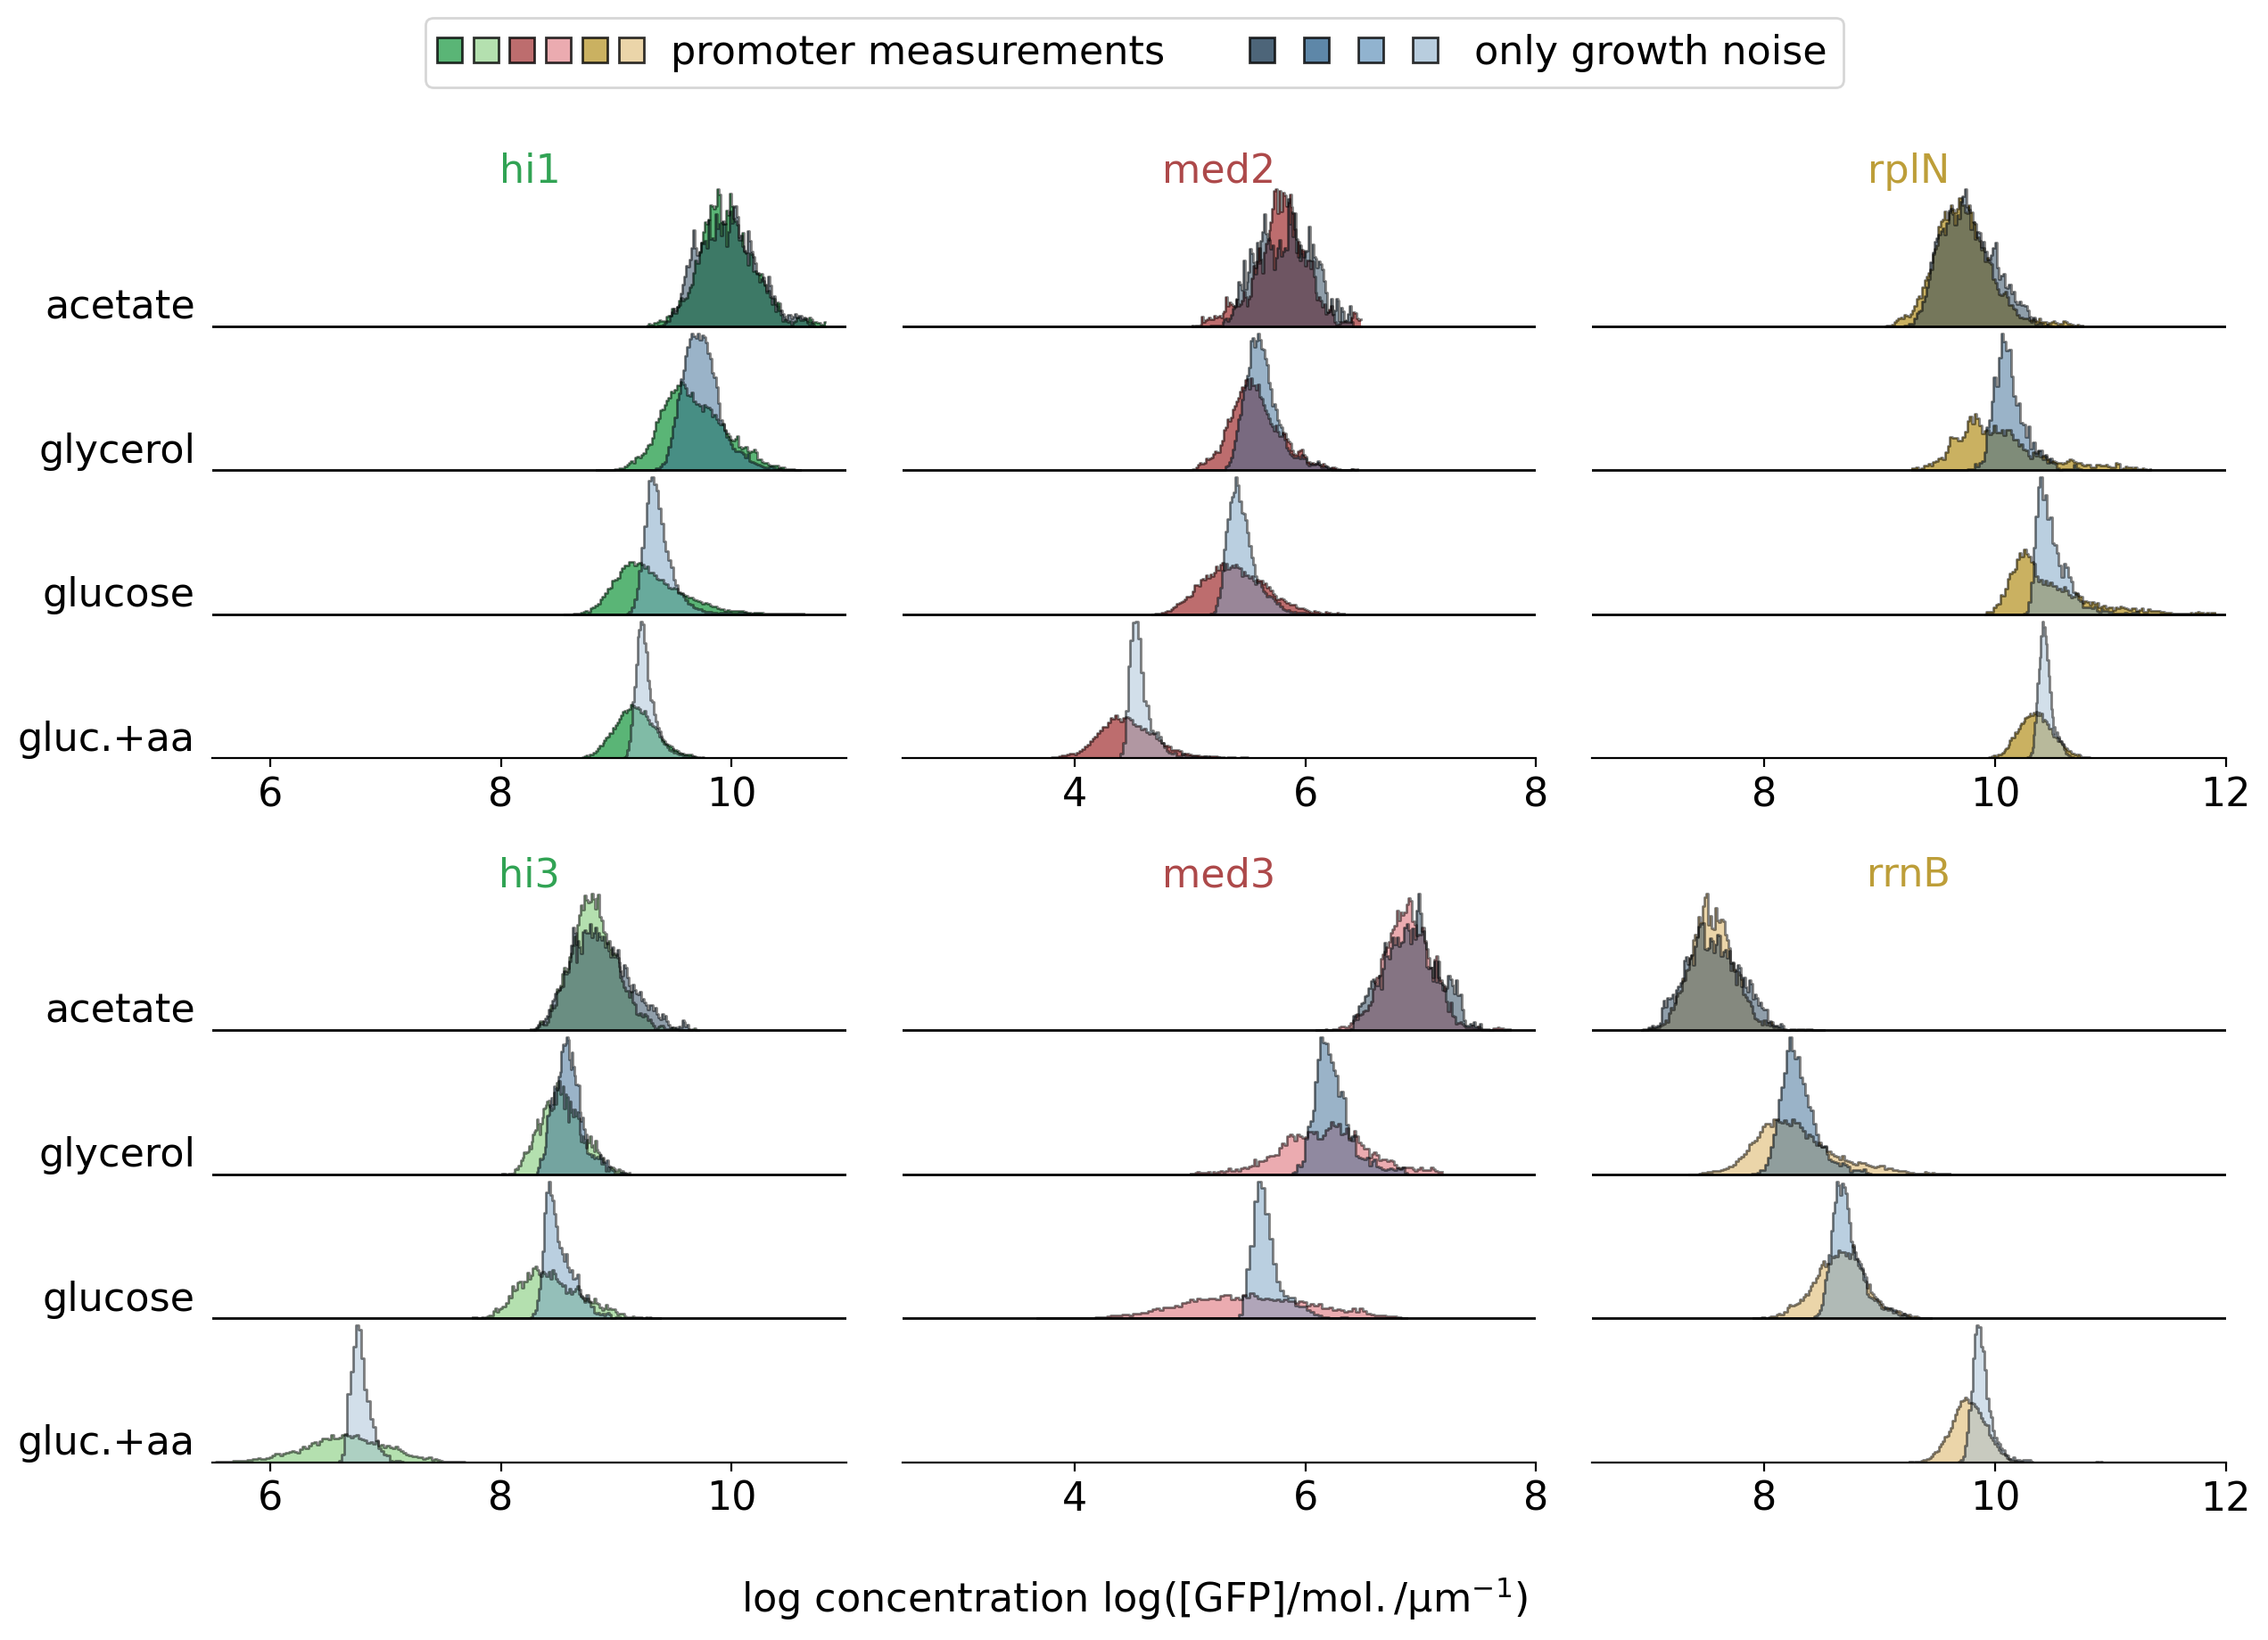

In [5]:
def plot_log_concentration_histograms_v(samples, hist_width=1, bins=30, 
                                        plot_file=None, 
                                        second_color=None,
                                        noise_settings=["cells", "cells_no_div_no_prod_noise"], grey_label=None):
    fig, axes = plt.subplots(2, 3, figsize=(FULL_SIZE, FULL_SIZE*2/3), sharex=False, sharey=True)
    ax = axes.transpose().ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.spines['left'].set_color('none')
        a.yaxis.tick_left()
        a.yaxis.set_ticks_position('none') 

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[4].get_shared_x_axes().join(ax[4], ax[5])


    condition_xtick = {cond: m for cond,m  in zip(conditions, np.arange(4)[::-1])}

    p_legend=[None]*len(ax)

    for i, promoter in enumerate(promoters):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            # color = color_by_condition[samples[sample]["condition"]]
            # color = color_by_both[samples[sample]["promoter"]][samples[sample]["condition"]]
            
            color = color_by_promoter[samples[sample]["promoter"]]
            
            ###
            all_conc = np.concatenate([get_log_concentrations(samples[sample]["cells"]), get_log_concentrations(samples[sample]["cells_no_div_no_prod_noise"])])
            bins = np.linspace(np.min(all_conc), np.max(all_conc), 100)
            b1, e1 = np.histogram(get_log_concentrations(samples[sample][noise_settings[0]]), bins=bins)
            b2, e2 = np.histogram(get_log_concentrations(samples[sample][noise_settings[1]]), bins=e1)    
            # print(promoter,samples[sample]["condition"],  np.std(get_log_concentrations(samples[sample][noise_settings[0]])))
            # print(promoter,samples[sample]["condition"],  np.std(get_log_concentrations(samples[sample][noise_settings[1]])))
            ###
            bin_norm = np.max([np.max(b1),np.max(b2)])
            b1=b1/bin_norm*hist_width
            b2=b2/bin_norm*hist_width

            # x = samples[sample]["l_mean"]*60
            x = condition_xtick[samples[sample]["condition"]]
            p_legend[i] = ax[i].bar(e1[:-1] + np.diff(e1), b1, np.diff(e1), bottom=x, lw = 2, alpha=0.8, 
                                    color=color)
            ax[i].step(e1[:-1] + np.diff(e1), x+b1, where="mid",  lw = 1, alpha=0.5, color="black")
            
            if second_color!=None:
                color_growth = second_color
            else:
                color_growth = color_by_condition[samples[sample]["condition"]]
            

            ax[i].bar(e2[:-1] + np.diff(e2), b2, np.diff(e2), bottom=x, lw = 2, alpha=0.5, color=color_growth)
            ax[i].step(e2[:-1] + np.diff(e2), x+b2, where="mid",  lw = 1, alpha=0.5, color="black")

            ax[i].axhline(x, lw=1, color="black", alpha=1)
            ax[i].set_yticks([])
            ax[i].set_title(promoter, y=0.94, color=color_by_promoter_cat[samples[sample]["promoter"]])
            ax[i].set_yticks(np.arange(4)[::-1], )
            ax[i].set_yticklabels( conditions_labels, fontdict={'verticalalignment':"bottom"})
 

    ax[1].set_xlim([5.5, 11.0])
    ax[3].set_xlim([2.5,8.0])
    ax[5].set_xlim([6.5,12.0])

    colors_for_legend1 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=10,marker='s',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]
    if second_color!=None:
        colors_for_legend2 = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                            color=second_color, alpha=0.8, marker='s', markersize=10, linestyle='None',
                                            label=grey_label) for k in [0]]
    else:
        colors_for_legend2 = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                            color=color_by_condition[k], alpha=0.8, marker='s', markersize=10, linestyle='None',
                                            label=grey_label) for k in color_by_condition.keys()]

    # colors_for_legend2 = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
    #                                     color="tab:grey", alpha=0.5, marker='s', markersize=10, linestyle='None',
    #                                     label=grey_label) for i in [1]]

    from matplotlib.legend_handler import HandlerTuple
    l = fig.legend([tuple(colors_for_legend1),
                    tuple(colors_for_legend2) ], 
                    ['promoter measurements', grey_label],
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=2, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 5)  
         

    fig.supxlabel("log concentration log([GFP]$/\mathrm{mol. /\mu m^{-1}}$)", y=0.02)

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')

    plt.show()

plot_log_concentration_histograms_v(first_replicates, 
                                    hist_width=0.95, 
                                    noise_settings=["cells", "cells_no_div_no_prod_noise"], 
                                    grey_label="only growth noise",
                                    plot_file="../../figures_for_fluctuations_paper/only_growth_noise_hist.pdf")


In [6]:
def is_first_cell_in_lineage(cell, cells):
    pid = cell.parent_id
    for c in cells:
        if c.cell_id == pid:
            return False
    return True


############# get * concentrations  #############
def get_log_concentrations(cells):
    c = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return c[np.isfinite(c)]
    # return np.concatenate([cell.log_concentration for cell in cells ])

def get_log1_concentrations(cells):
    return np.concatenate([cell.log1_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_finite_log_concentrations(cells):
    lc = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return lc[np.isfinite(lc)]

def get_concentrations(cells):
    return np.concatenate([ cell.concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

############# get log gfp  #############
def get_finite_log_gfp(cells):
    g = np.concatenate([np.log(cell.gfp) for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g[np.isfinite(g)]

############# get concentration std  #############
def get_concentration_std(cells):
    return np.std( get_concentrations(cells) )


def get_concentration_mean(cells):
    return np.mean( get_concentrations(cells) )

def get_concentration_median(cells):
    return np.median( get_concentrations(cells) )

def get_log_concentration_mean(cells):
    return np.mean( get_finite_log_gfp(cells) )

def get_log_concentration_std(cells):
    return np.std( get_finite_log_gfp(cells) )

def estimate_iqr(c):
    return np.subtract(*np.percentile(c, [75, 25]))

def get_log_concentration_iqr(cells):
    return estimate_iqr( get_finite_log_concentrations(cells) )

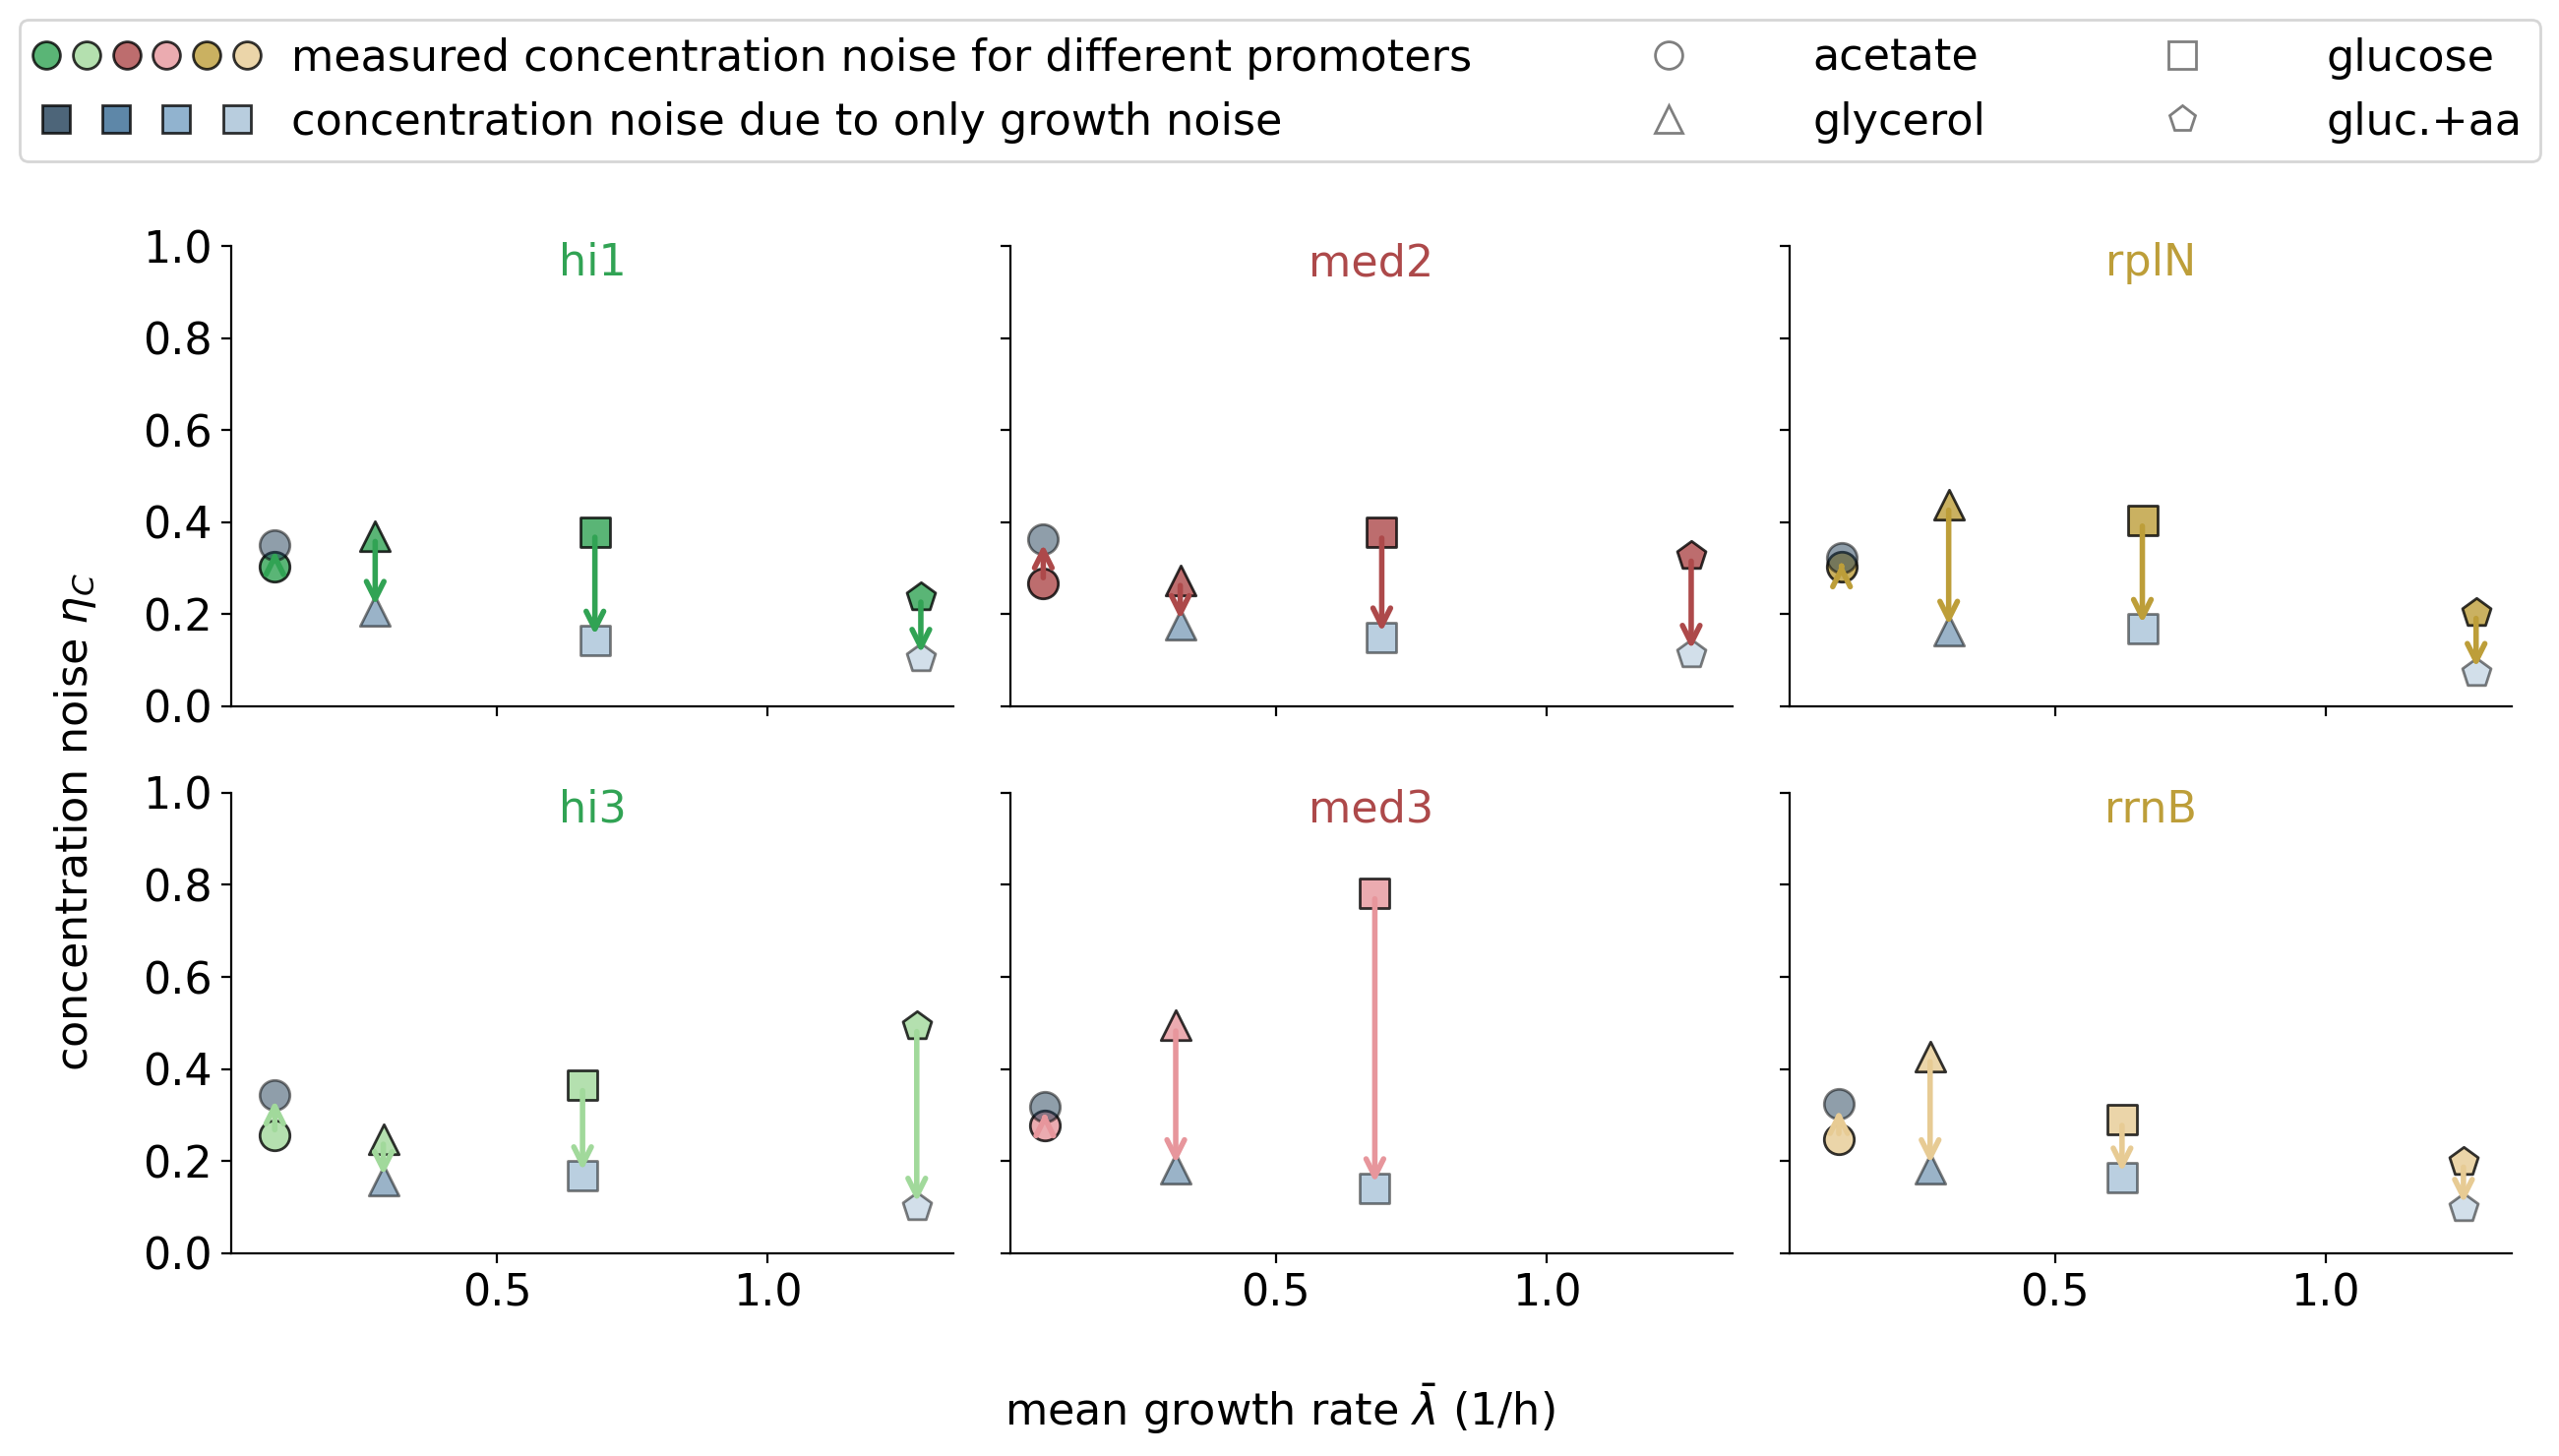

In [7]:

def plot_log_concentration_iqr(samples, 
                               noise_settings=[], 
                               grey_label=None, 
                               plot_file=None,
                               arrow=True):
    fig, axes = plt.subplots(2,3, figsize=(FULL_SIZE,FULL_SIZE/2), sharex=True , sharey=True)
    ax = axes.transpose().ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    for i, promoter in enumerate(promoters):
        x0s = []
        x1s = []
        iqr0s = []
        iqr1s = []

        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            # color = color_by_condition[samples[sample]["condition"]]
            
            color = color_by_promoter[samples[sample]["promoter"]]
            marker = marker_by_condition[samples[sample]["condition"]]

            iqr0 = get_log_concentration_iqr(samples[sample][noise_settings[0]])
            # x0 = get_log_concentration_mean(samples[sample][noise_settings[0]])
            x0 = samples[sample]["l_mean"]*60
            x0s.append(x0)
            iqr0s.append(iqr0)

            iqr1 = get_log_concentration_iqr(samples[sample][noise_settings[1]])
            # x1 = get_log_concentration_mean(samples[sample][noise_settings[1]])
            x1 = samples[sample]["l_mean"]*60
            x1s.append(x1)
            iqr1s.append(iqr1)

            ax[i].scatter(x0, iqr0, s=120, alpha=0.8, color=color, label=samples[sample]["condition"], ec=list(mcolors.to_rgb('black')) + [1], marker=marker)
            ax[i].scatter(x1, iqr1, s=120,alpha=0.5, color=color_by_condition[samples[sample]["condition"]], label=grey_label, ec=list(mcolors.to_rgb('black')) + [1], marker=marker)
            if arrow:
                ax[i].annotate('', xy=[x0, iqr0], xytext=[x1, iqr1], arrowprops=dict(arrowstyle='<-', lw=2,color=color))

            samples[sample]["iqr_only_growth_noise"] = iqr1
            
            ax[i].set_title(promoter, y=0.9, color=color_by_promoter_cat[promoter])
            # print(iqr0, samples[sample]["condition"], samples[sample]["promoter"])
        ax[i].set_ylim(0, 1)
        sort0 = np.argsort(x0s)
        # ax[i].plot(np.array(x0s)[sort0], np.array(iqr0s)[sort0],  color="black", ls='--', zorder=-1)

        sort1 = np.argsort(x1s)
        # ax[i].plot(np.array(x1s)[sort1], np.array(iqr1s)[sort1], color="tab:grey", zorder=-1)


    colors_for_legend1 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=10,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    marker_for_legend = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color="None", alpha=0.5, marker=marker_by_condition[k], markersize=10, linestyle='None',
                                        label=k) for k in marker_by_condition.keys()]
    
    

    colors_for_legend2 = [mlines.Line2D([], [], markeredgecolor=list(mcolors.to_rgb('black')), 
                                        color=color_by_condition[k], alpha=0.8, marker='s', markersize=10, linestyle='None',
                                        label=grey_label) for k in color_by_condition.keys()]




    
    from matplotlib.legend_handler import HandlerTuple
    l = fig.legend([ tuple(colors_for_legend1), 
                    tuple(colors_for_legend2) ,
                    tuple(marker_for_legend[0:1]), 
                    tuple(marker_for_legend[1:2]),
                    tuple(marker_for_legend[2:3]),
                    tuple(marker_for_legend[3:4])], 
                   ['measured concentration noise for different promoters', 
                    grey_label, 
                    conditions_labels[0], conditions_labels[1], conditions_labels[2], conditions_labels[3]],
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=3, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 5)   

    fig.supxlabel(r"mean growth rate $\bar{\lambda}$ (1/h)", y=0.02)
    fig.supylabel(r"concentration noise $\eta_C$")
    

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()
    return samples



setting_to_compare = ["cells", "cells_no_div_no_prod_noise"]
first_replicates = plot_log_concentration_iqr(first_replicates, 
                           noise_settings=setting_to_compare, 
                           grey_label="concentration noise due to only growth noise",
                           plot_file="../../figures_for_fluctuations_paper/supp/IQR_changes.pdf")

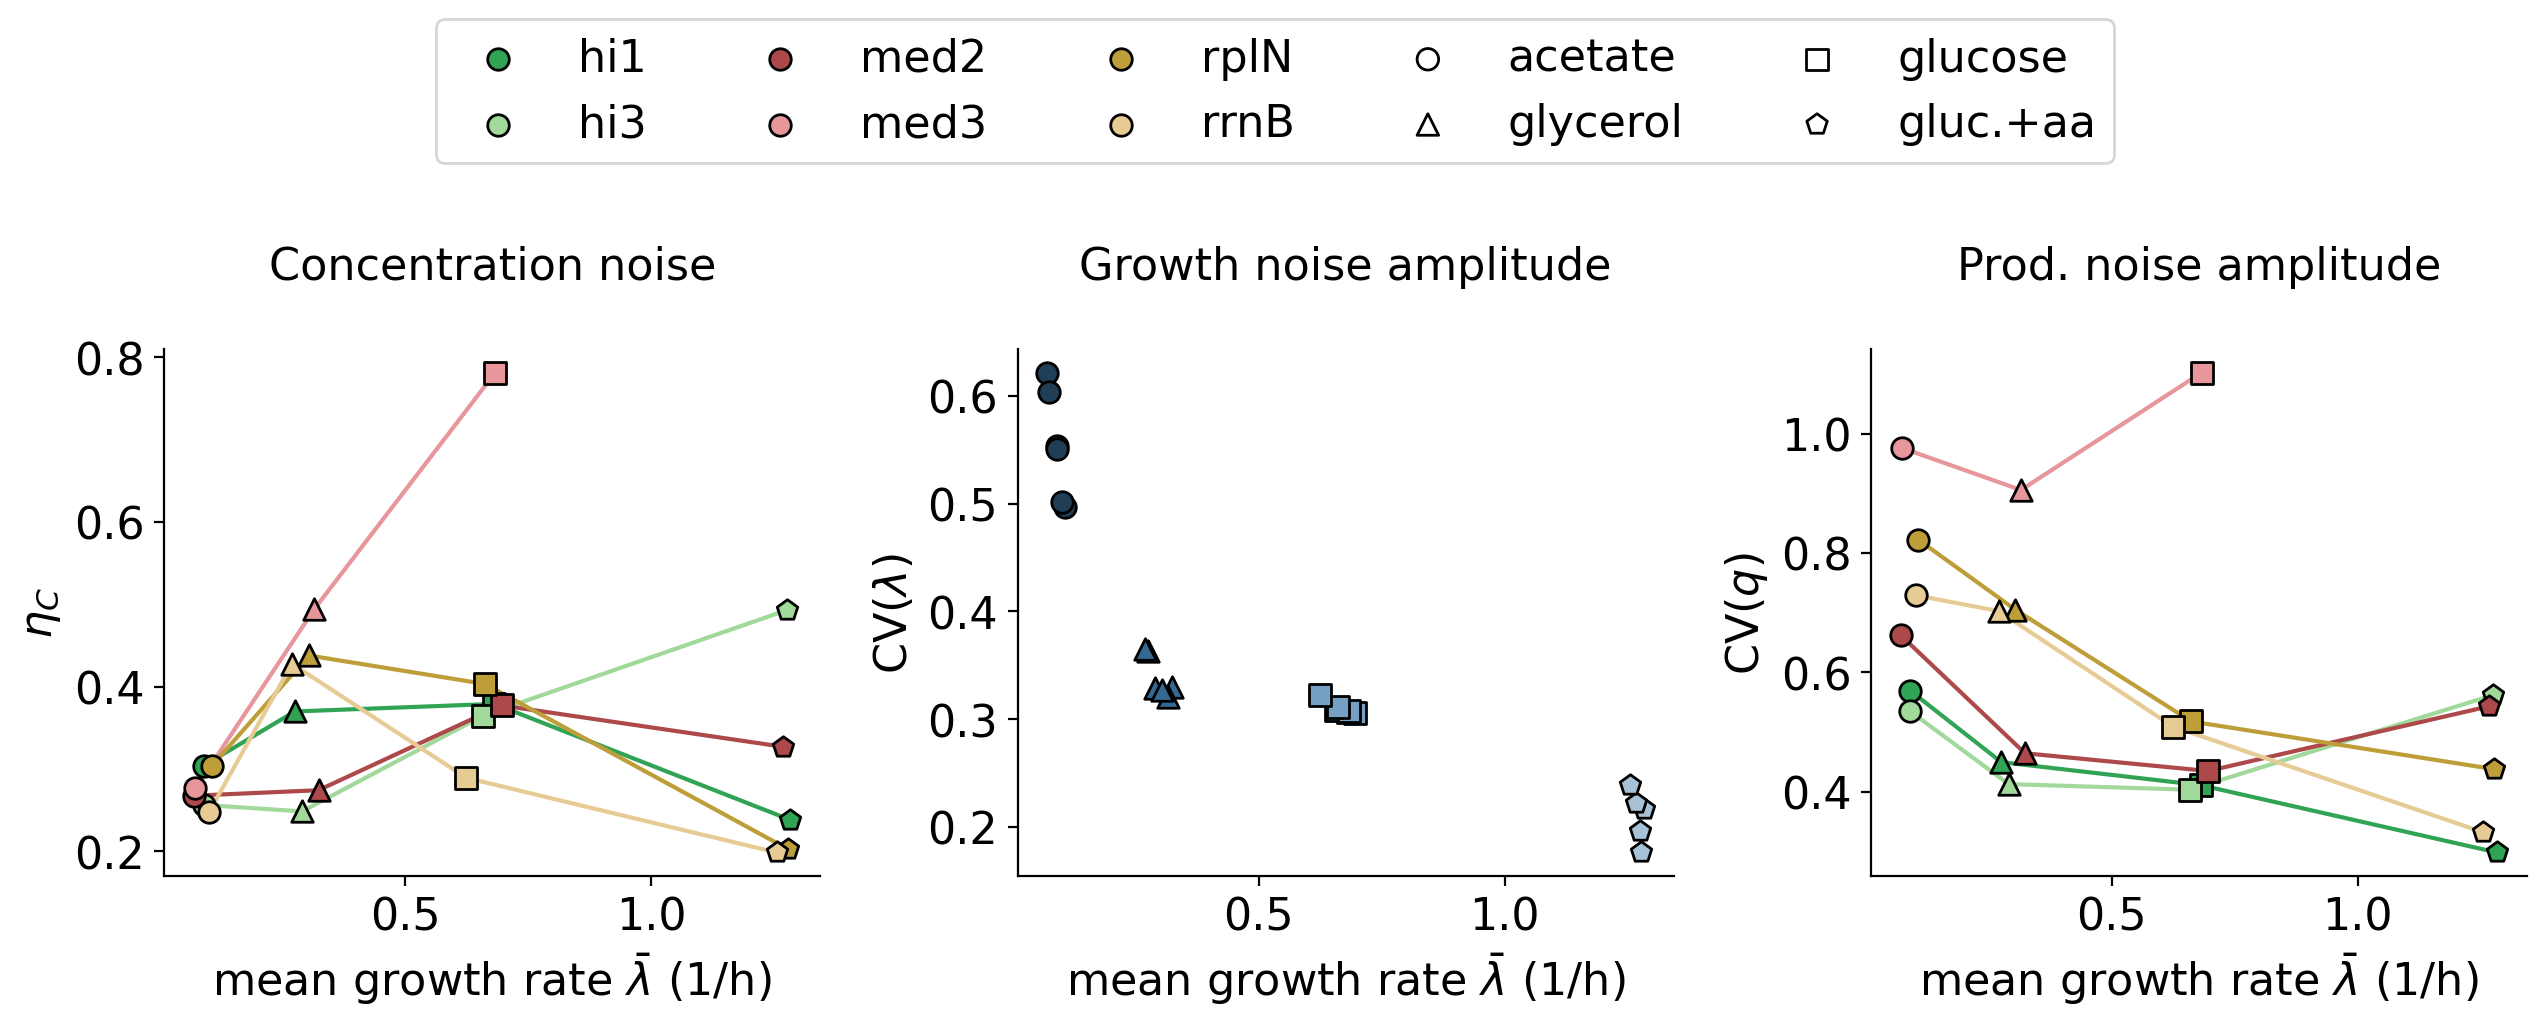

In [8]:

def plot_log_concentration_iqr_cvl_cvq(samples, grey_label=None, plot_file=None):
    # fig, axes = plt.subplots(2, 3, figsize=(15, 7.5), sharex=False, sharey=True)
    fig, ax = plt.subplots(1,3, figsize=(FULL_SIZE,FULL_SIZE/3))
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        a.set_xlabel(r"mean growth rate $\bar{\lambda}$ (1/h)")

    for i, promoter in enumerate(promoters):
        mean_growth_rates = []
        etas = []
        cvls = []
        cvqs = []
        for sample in sort_by_condition(samples.keys()):
            if samples[sample]["promoter"] != promoter:
                continue
            # color = color_by_condition[samples[sample]["condition"]]
            
            color = color_by_promoter[samples[sample]["promoter"]]
            color_condition = color_by_condition[samples[sample]["condition"]]
            marker = marker_by_condition[samples[sample]["condition"]]

            iqr0 = get_log_concentration_iqr(samples[sample]["cells"])
            x0 = samples[sample]["l_mean"]*60
            
            # save for lines
            mean_growth_rates.append(x0)
            etas.append(iqr0)
            cvls.append(samples[sample]["l_cv"])
            cvqs.append(samples[sample]["q_cv"])

            ax[0].scatter(x0, iqr0,  color=color, ec="black", s=60, marker=marker, label=promoter)
            ax[0].scatter(np.nan, np.nan,  color="None", ec="black", s=60, marker=marker, label=label_by_condition[samples[sample]["condition"]])
            
            ax[1].scatter(x0, samples[sample]["l_cv"],  color=color_condition, ec="black", s=60, marker=marker, label=promoter)
            ax[2].scatter(x0, samples[sample]["q_cv"],  color=color, ec="black", s=60, marker=marker, label=promoter)

        ax[0].plot(mean_growth_rates, etas, color=color_by_promoter[promoter], zorder=-1)
        # ax[1].plot(mean_growth_rates, cvls, color="tab:blue", zorder=-1)
        ax[2].plot(mean_growth_rates, cvqs, color=color_by_promoter[promoter], zorder=-1)
    
    from matplotlib.legend_handler import HandlerTuple
    l = fig.legend(*legend_without_duplicate_labels(ax[0], sorting=promoters+list(label_by_condition.values())),
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", ncol=5)

    
    ax[0].set_ylabel(r"$\eta_C$")
    ax[0].set_title(r"Concentration noise", y=1.1)
        
    ax[1].set_ylabel(r"CV($\lambda$)")
    ax[1].set_title(r"Growth noise amplitude", y=1.1)
    
    ax[2].set_ylabel(r"CV($q$)")
    ax[2].set_title(r"Prod. noise amplitude", y=1.1)
    

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()
    return samples



first_replicates = plot_log_concentration_iqr_cvl_cvq(first_replicates, 
                           grey_label="only growth noise",
                           plot_file="../../figures_for_fluctuations_paper/supp/IQR_cvl_cvq.pdf")

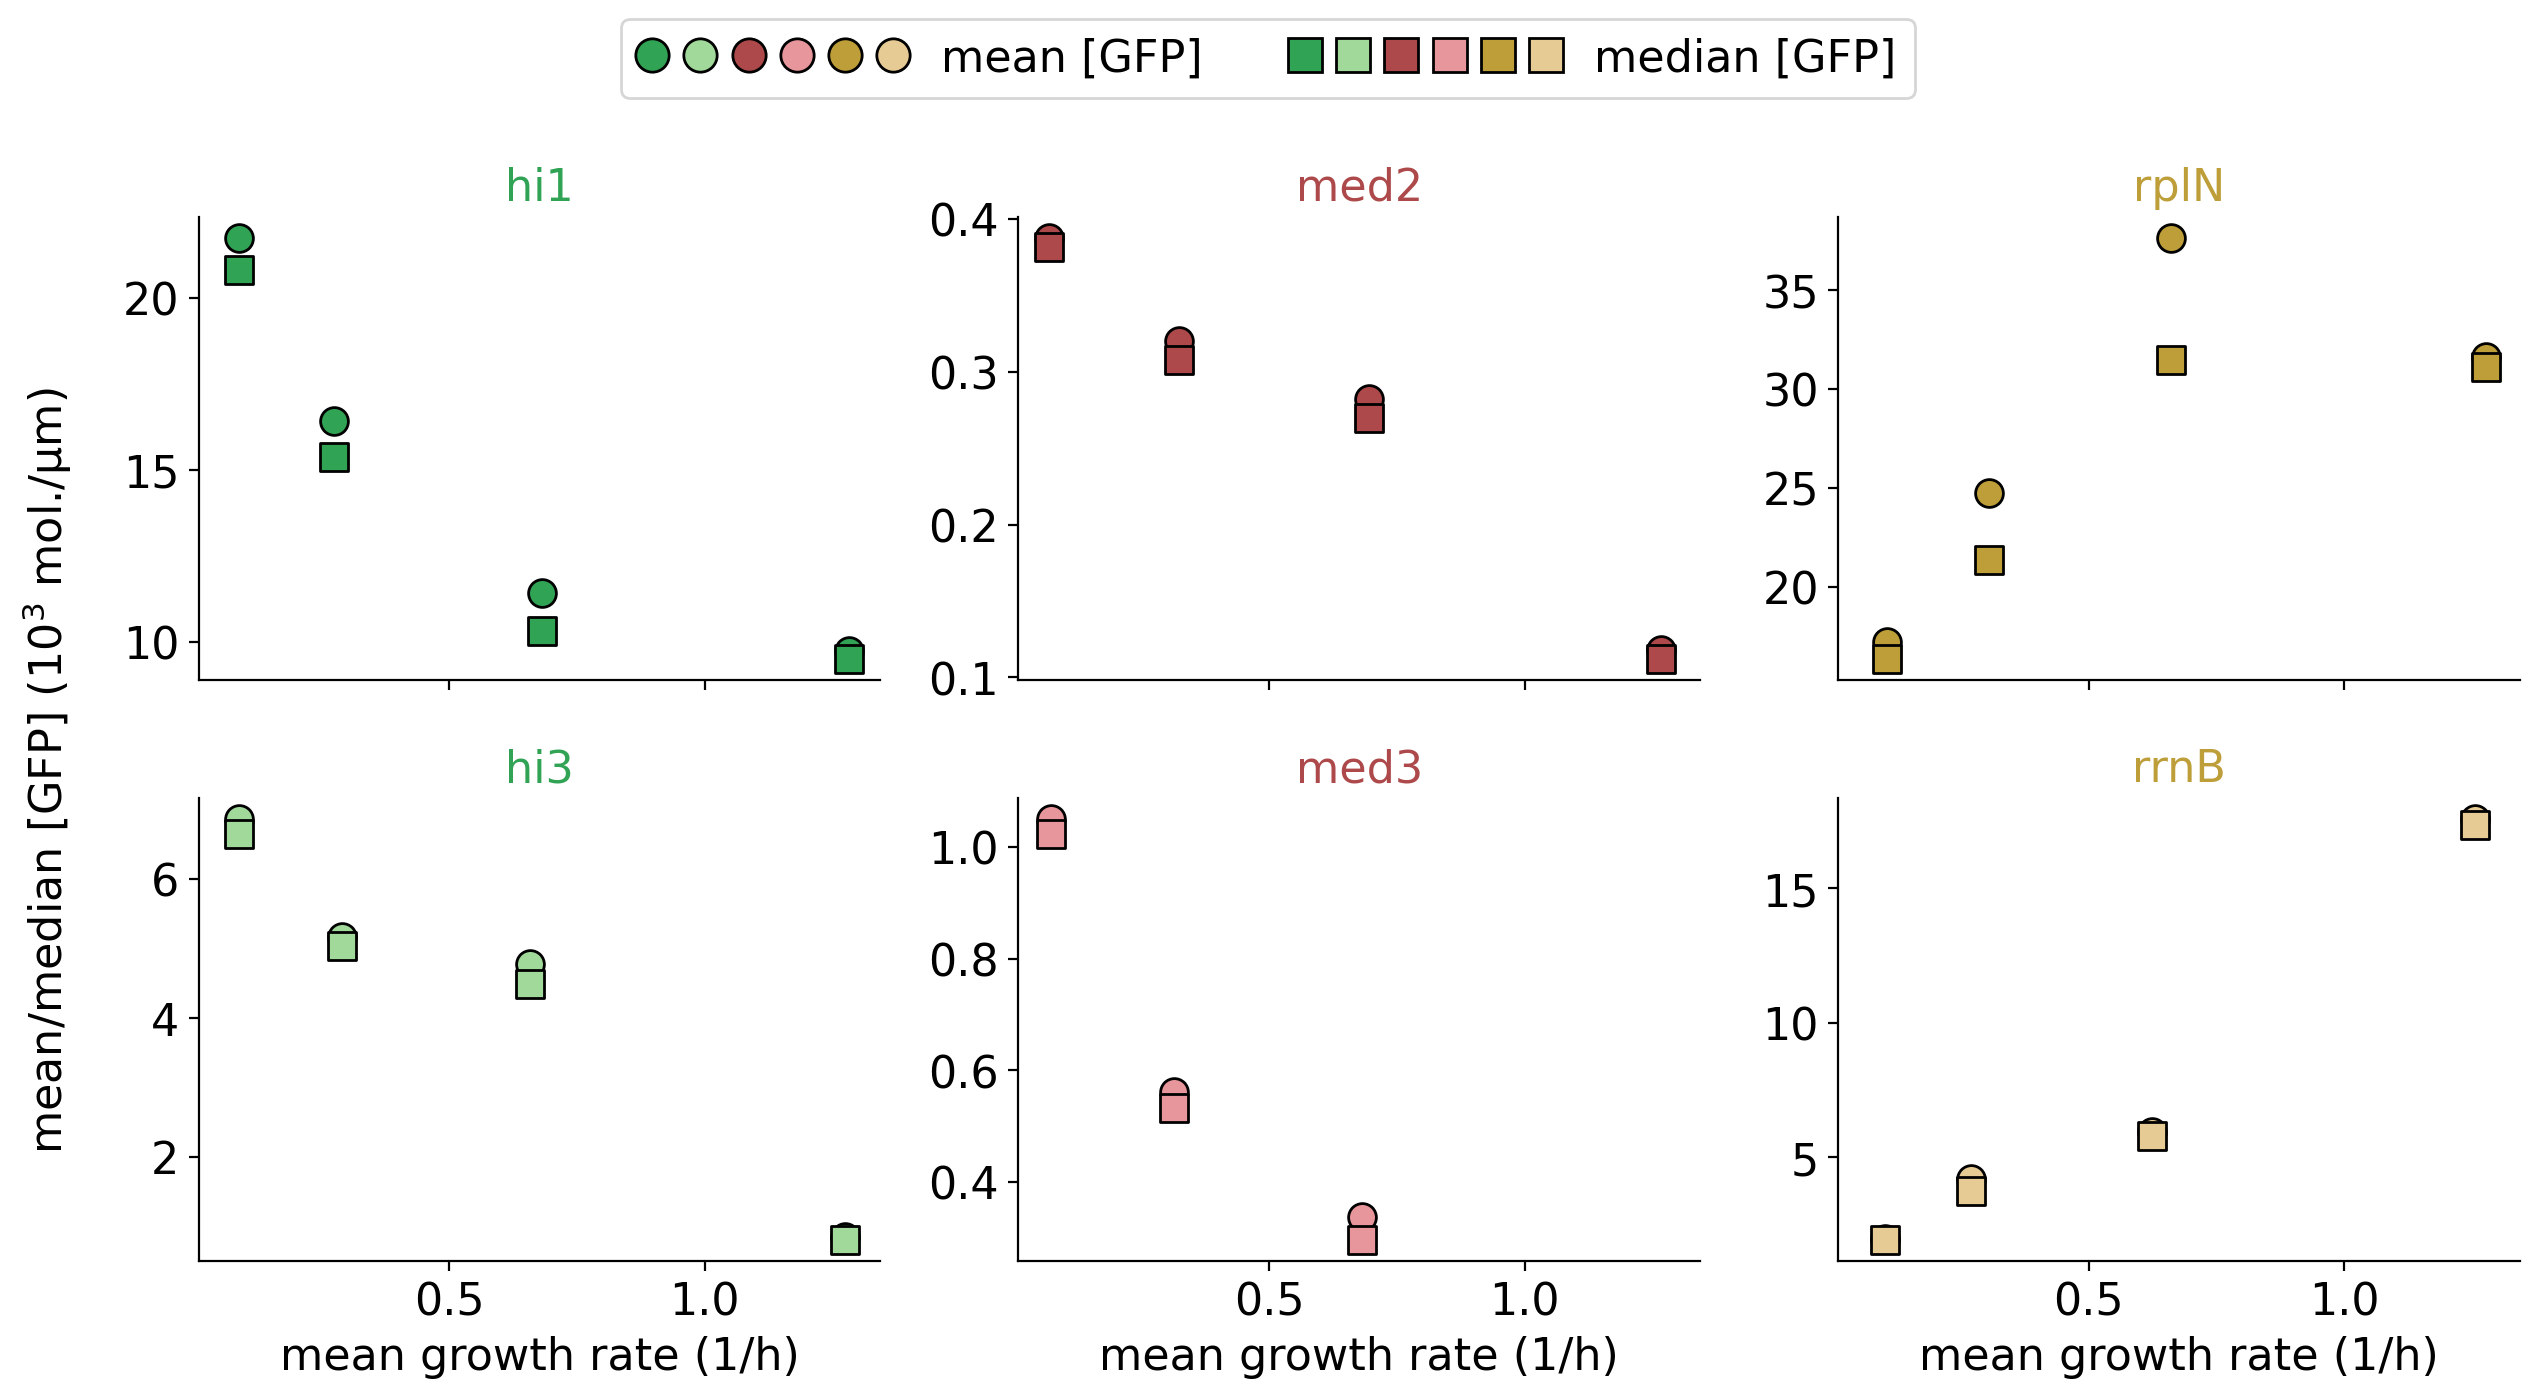

In [9]:
def plot_mean_concentration_vs_growth(samples, plot_file=None):
    fig, axes = plt.subplots(2, 3, figsize=(FULL_SIZE, FULL_SIZE/2), sharex=True, sharey=False)
    ax = axes.transpose().ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    condition_xtick = {cond: m for cond,m  in zip(conditions, np.arange(4))}

    for i, promoter in enumerate(promoters):
        ticks = []
        ticks_labels = []
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]

            cells = samples[sample]["ggp_cells"]
            ax[i].scatter(samples[sample]["l_mean"]*60,  get_concentration_mean(cells)/1e3, 
                          color=color, s=100, ec="black")
            
            ticks.append(samples[sample]["l_mean"]*60)
            ticks_labels.append(label_by_condition[samples[sample]["condition"]])
            
            ax[i].scatter(samples[sample]["l_mean"]*60,  get_concentration_median(cells)/1e3, 
                          color=color, s=100, ec="black", marker="s")
            
            ax[i].set_title(promoter, color=color_by_promoter_cat[samples[sample]["promoter"]])
            

        # ax[i].set_xticks(ticks)
        # ax[i].set_xticklabels(ticks_labels, rotation=-40)
            
    colors_for_legend1 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')), 
                                        color=color_by_promoter[k],alpha=1, markersize=12,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]
    
    colors_for_legend2 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')), 
                                        color=color_by_promoter[k],alpha=1, markersize=12,marker='s',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    from matplotlib.legend_handler import HandlerTuple
    l = fig.legend([ tuple(colors_for_legend1),
                     tuple(colors_for_legend2) ], 
                   ['mean [GFP]', 'median [GFP]'],
                   handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                   bbox_to_anchor=(0.5, 1), 
                   loc="lower center", 
                   ncol=2, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], 
                    handlelength = 6)
         
            
    fig.supylabel("mean/median [GFP] ($10^{3}$ mol./$\mathrm{\mu m}$)")
    ax[1].set_xlabel("mean growth rate (1/h)")
    ax[3].set_xlabel("mean growth rate (1/h)")
    ax[5].set_xlabel("mean growth rate (1/h)")

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')

    plt.show()

    plt.show()

plot_mean_concentration_vs_growth(first_replicates,plot_file="../../figures_for_fluctuations_paper/supp/mean_median_concentration.pdf")



In [10]:
def get_corr_label(x,y,decimals=2):
    c = np.around(np.corrcoef(x,y)[0,1], decimals)
    return "R={:.2f}".format(c) 

In [11]:
def lin_func(x,a,b):
    return a*np.array(x)+b

def lin_func_no_b(x,a,b):
    return a*np.array(x)

def lin_fit(x,y, use_b=True):
    if use_b:
        popt, pcov = scipy.optimize.curve_fit(lin_func, x, y)
    else:
        popt, pcov = scipy.optimize.curve_fit(lin_func, x, y, p0=[1,0])
        popt[1]=0
    return popt, pcov 

In [12]:
df = pd.DataFrame([[True, False],[False, True]], columns=[1,2], index=[1,2])
df.loc[1,1] == True

True

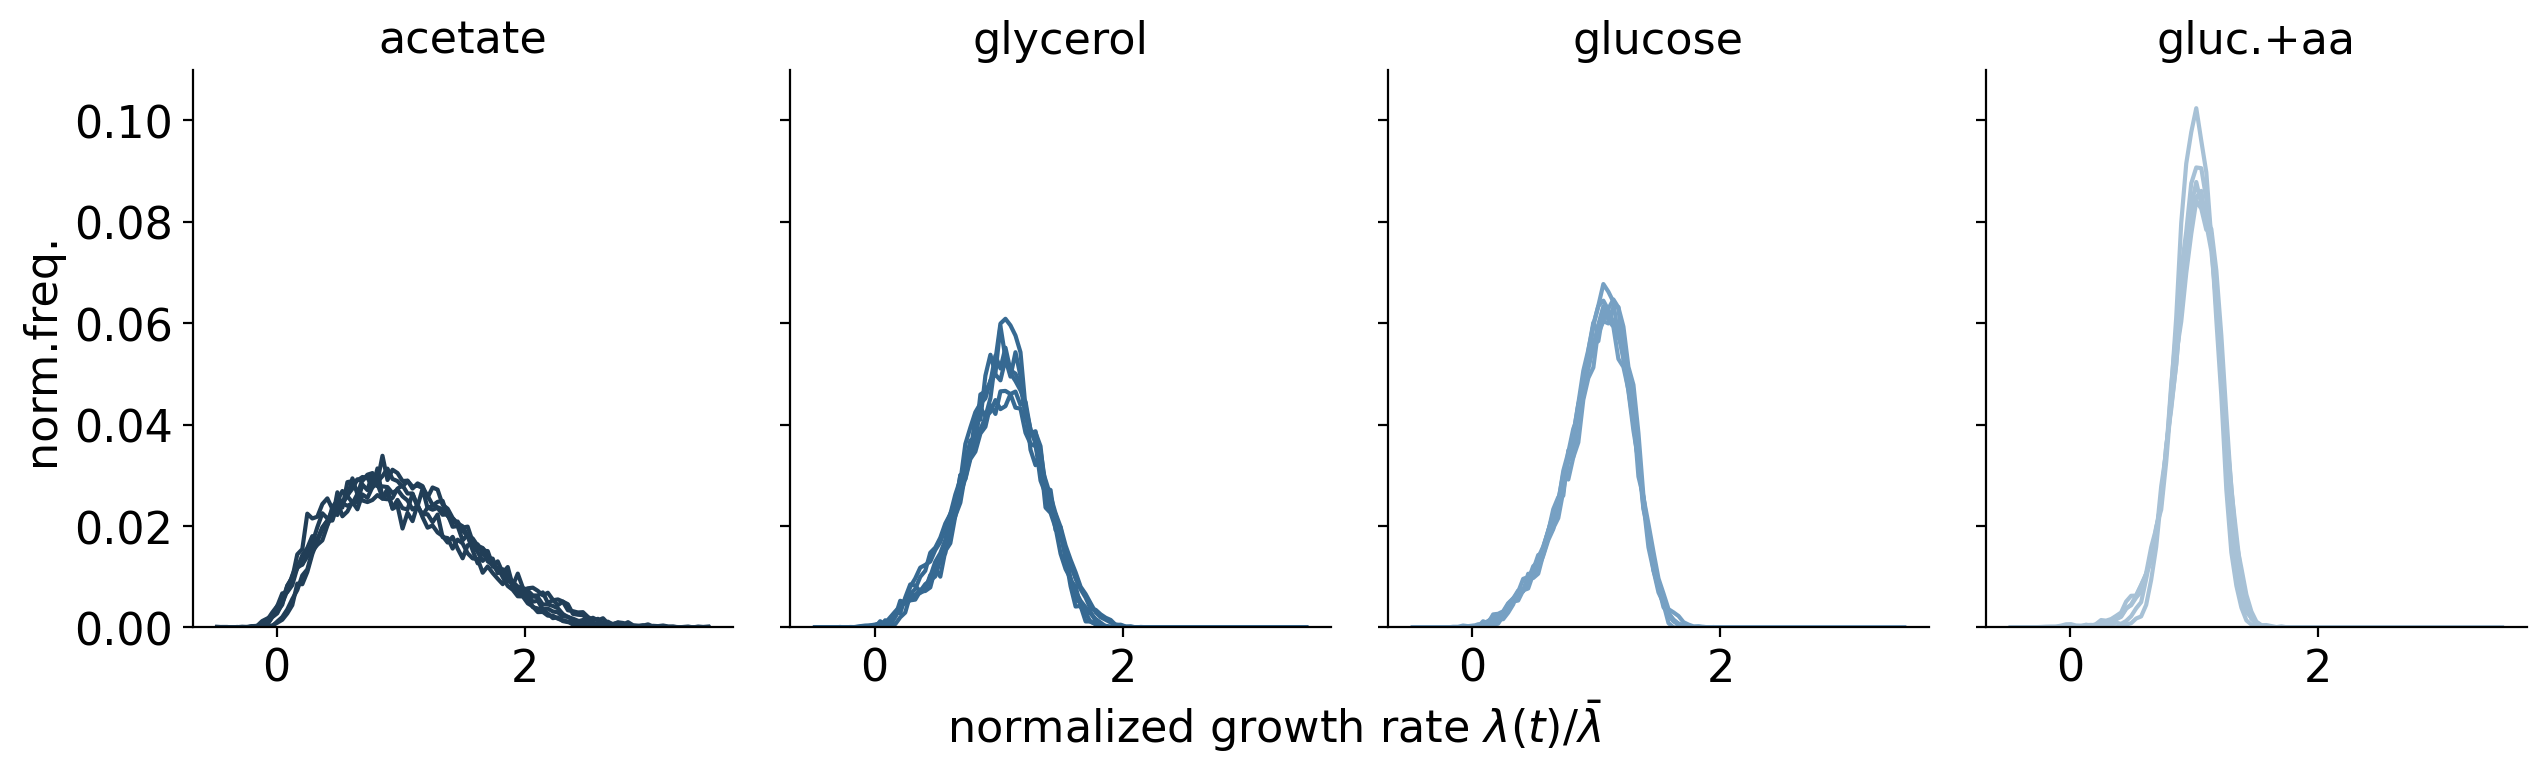

In [13]:

def bin_with_error_bars(means, variances, n_bins=1000, return_edges=True, ignore_errors=False):
    if ignore_errors:
        if return_edges:
            return np.histogram(means, bins=n_bins)
        else:
            w, e = np.histogram(means, bins=n_bins)
            return w, e[:-1]+np.diff(e)/2.
        
    left = np.min(means) - 2*np.sqrt(variances[np.argmin(means)])
    right = np.max(means) + 2*np.sqrt(variances[np.argmax(means)])
    
    _,bin_edges = np.histogram(means, bins=np.linspace(left, right, n_bins))
    
    bin_c = bin_edges[:-1] +np.diff(bin_edges)/2
    weight = np.zeros_like(bin_c)
    for i, m in enumerate(means):
        weight += special.erf( (bin_edges[1:]-m)/np.sqrt(2*variances[i]) ) - special.erf( (bin_edges[:-1]-m)/np.sqrt(2*variances[i]) )
    if return_edges:
        return weight, bin_edges
    else:
        return weight, bin_c
    
def plot_growth_rate_noise(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(1, 4, figsize=(FULL_SIZE,FULL_SIZE/3), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_xlim(-1,4)
        a.set_ylim(0,0.11)

    for i, condition in enumerate(conditions):
        ax[i].set_title(label_by_condition[condition])
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            cells = samples[sample]['ggp_cells']
            mean_l = np.concatenate([cell.mean_l for cell in cells])/samples[sample]['l_mean']
            cov_ll = np.concatenate([cell.cov_ll for cell in cells])/samples[sample]['l_mean']**2
            
            weight, bin_c = bin_with_error_bars(mean_l, cov_ll, return_edges=False, ignore_errors=True, n_bins=np.linspace(-0.5,3.5,100))
            weight= np.array(weight)/np.sum(weight)
            ax[i].plot(bin_c, weight, color=color_by_condition[samples[sample]["condition"]])
            # ax[0].plot(bin_c, weight, color=altcolor_by_condition[condition])
            
    fig.supxlabel(r"normalized growth rate $\lambda(t)/ \bar{\lambda}$", y=0.1)
    ax[0].set_ylabel(r"norm.freq.")

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()

plot_growth_rate_noise(first_replicates, plot_file="../../figures_for_fluctuations_paper/supp/growth_rate_hist.pdf")


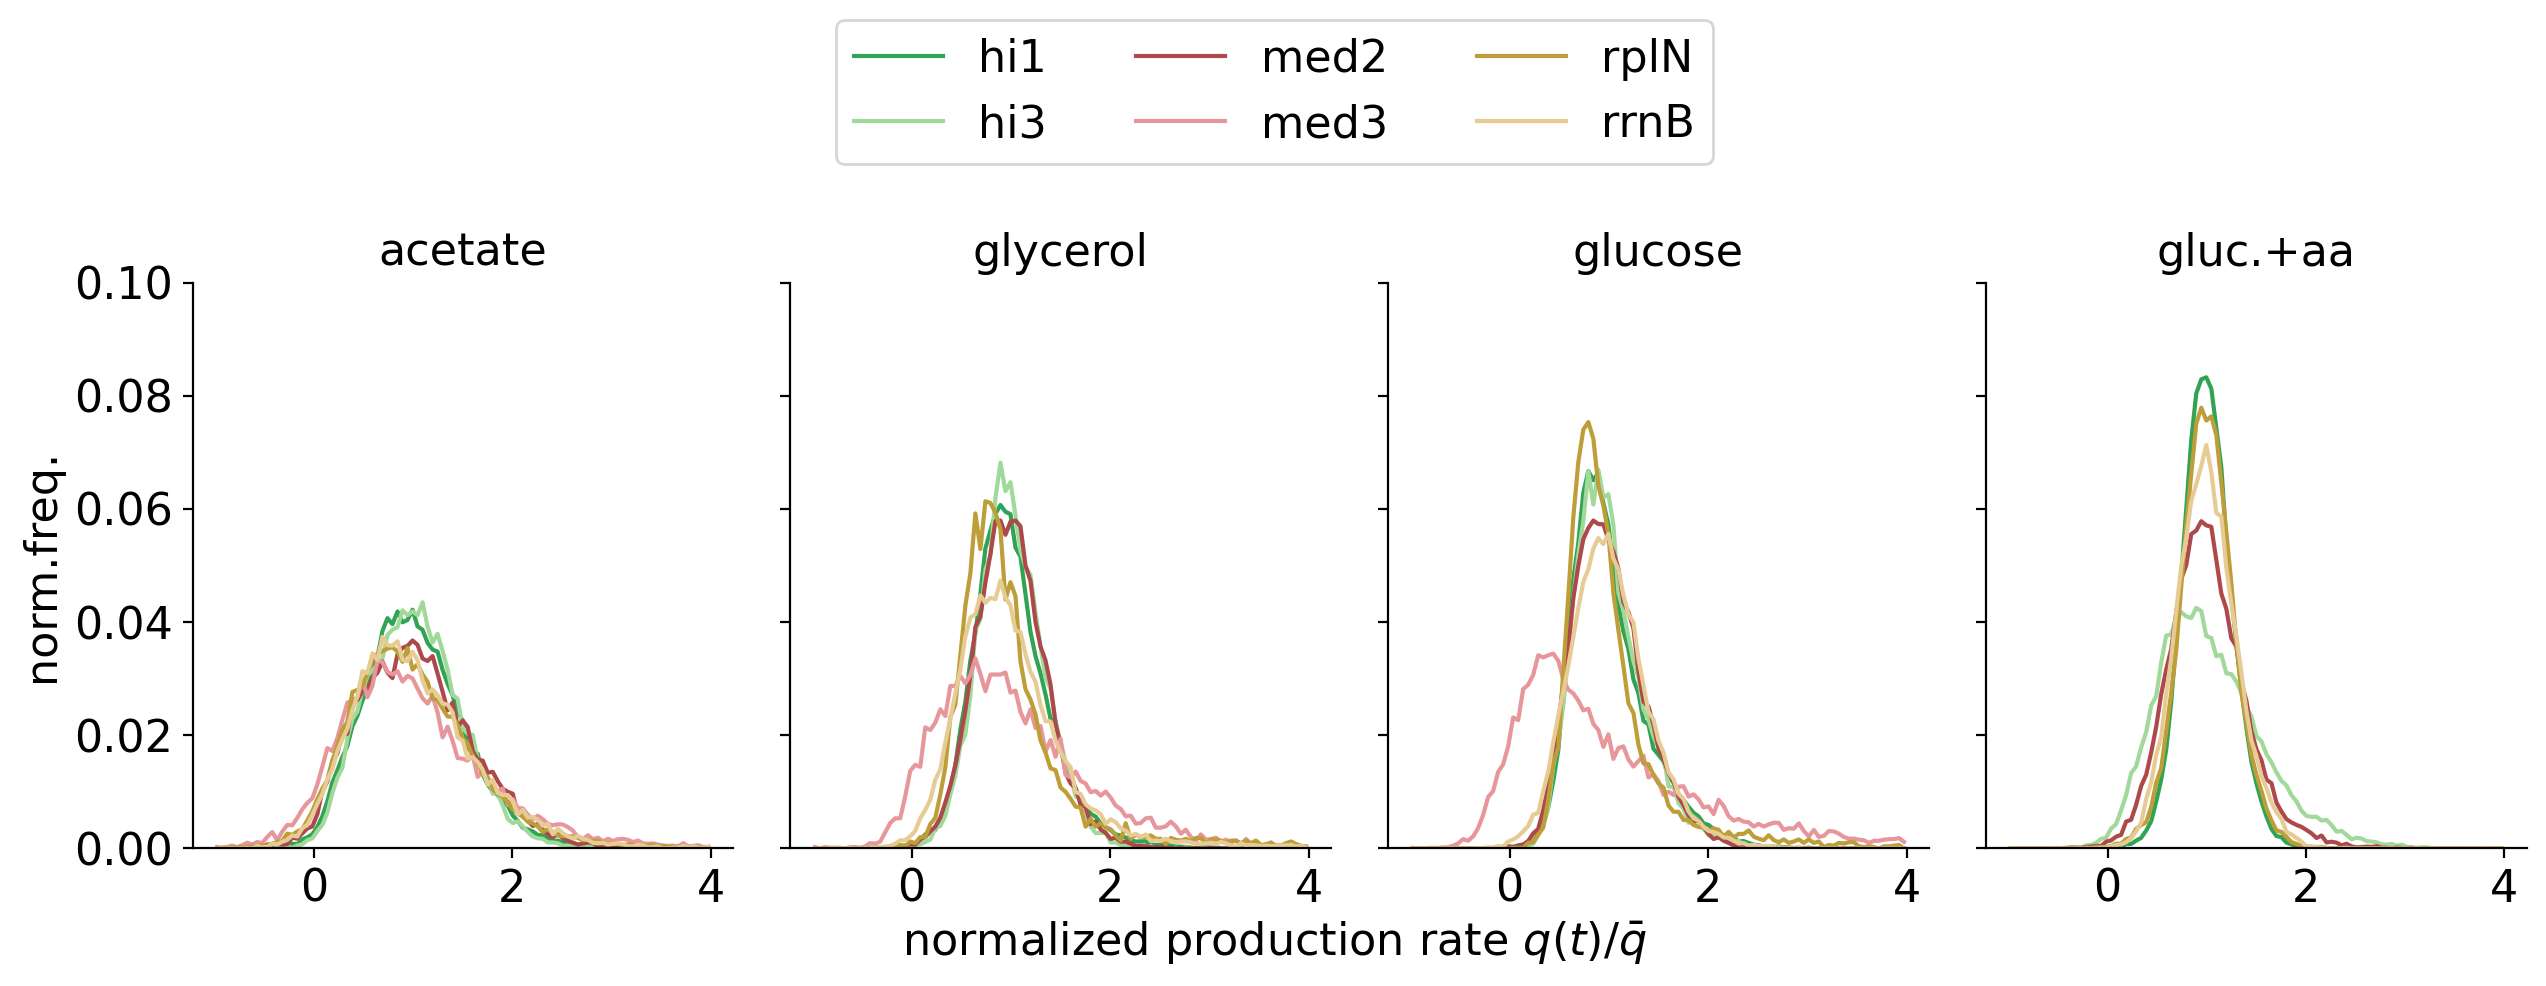

In [14]:
def plot_production_rate_noise(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(1,4, figsize=(FULL_SIZE,FULL_SIZE/3), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_xlim(-1,6)
        a.set_ylim(0, 0.1)
        # a.set_yscale("log")

    for i, condition in enumerate(conditions):
        ax[i].set_title(label_by_condition[condition])
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            cells = samples[sample]['ggp_cells']
            mean_q = np.concatenate([cell.mean_q for cell in cells])/samples[sample]['q_mean']
            cov_qq = np.concatenate([cell.cov_qq for cell in cells])/samples[sample]['q_mean']**2
            
            weight, bin_c = bin_with_error_bars(mean_q, cov_qq, return_edges=False, ignore_errors=True, n_bins=np.linspace(-1,4,100))
            weight= np.array(weight)/np.sum(weight)
            ax[i].plot(bin_c, weight, color=color_by_promoter[samples[sample]["promoter"]], label=samples[sample]["promoter"])
            # ax[0].plot(bin_c, weight, color=altcolor_by_condition[condition])
            
    fig.supxlabel(r"normalized production rate $q(t)/ \bar{q}$", y=0.1)
    ax[0].set_ylabel(r"norm.freq.")
    
        
    l = fig.legend(*legend_without_duplicate_labels(ax[0]),
            bbox_to_anchor=(0.5, 1), 
            loc="lower center", ncol=3)
    
    
    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()

plot_production_rate_noise(first_replicates, plot_file="../../figures_for_fluctuations_paper/supp/production_rate_hist.pdf")


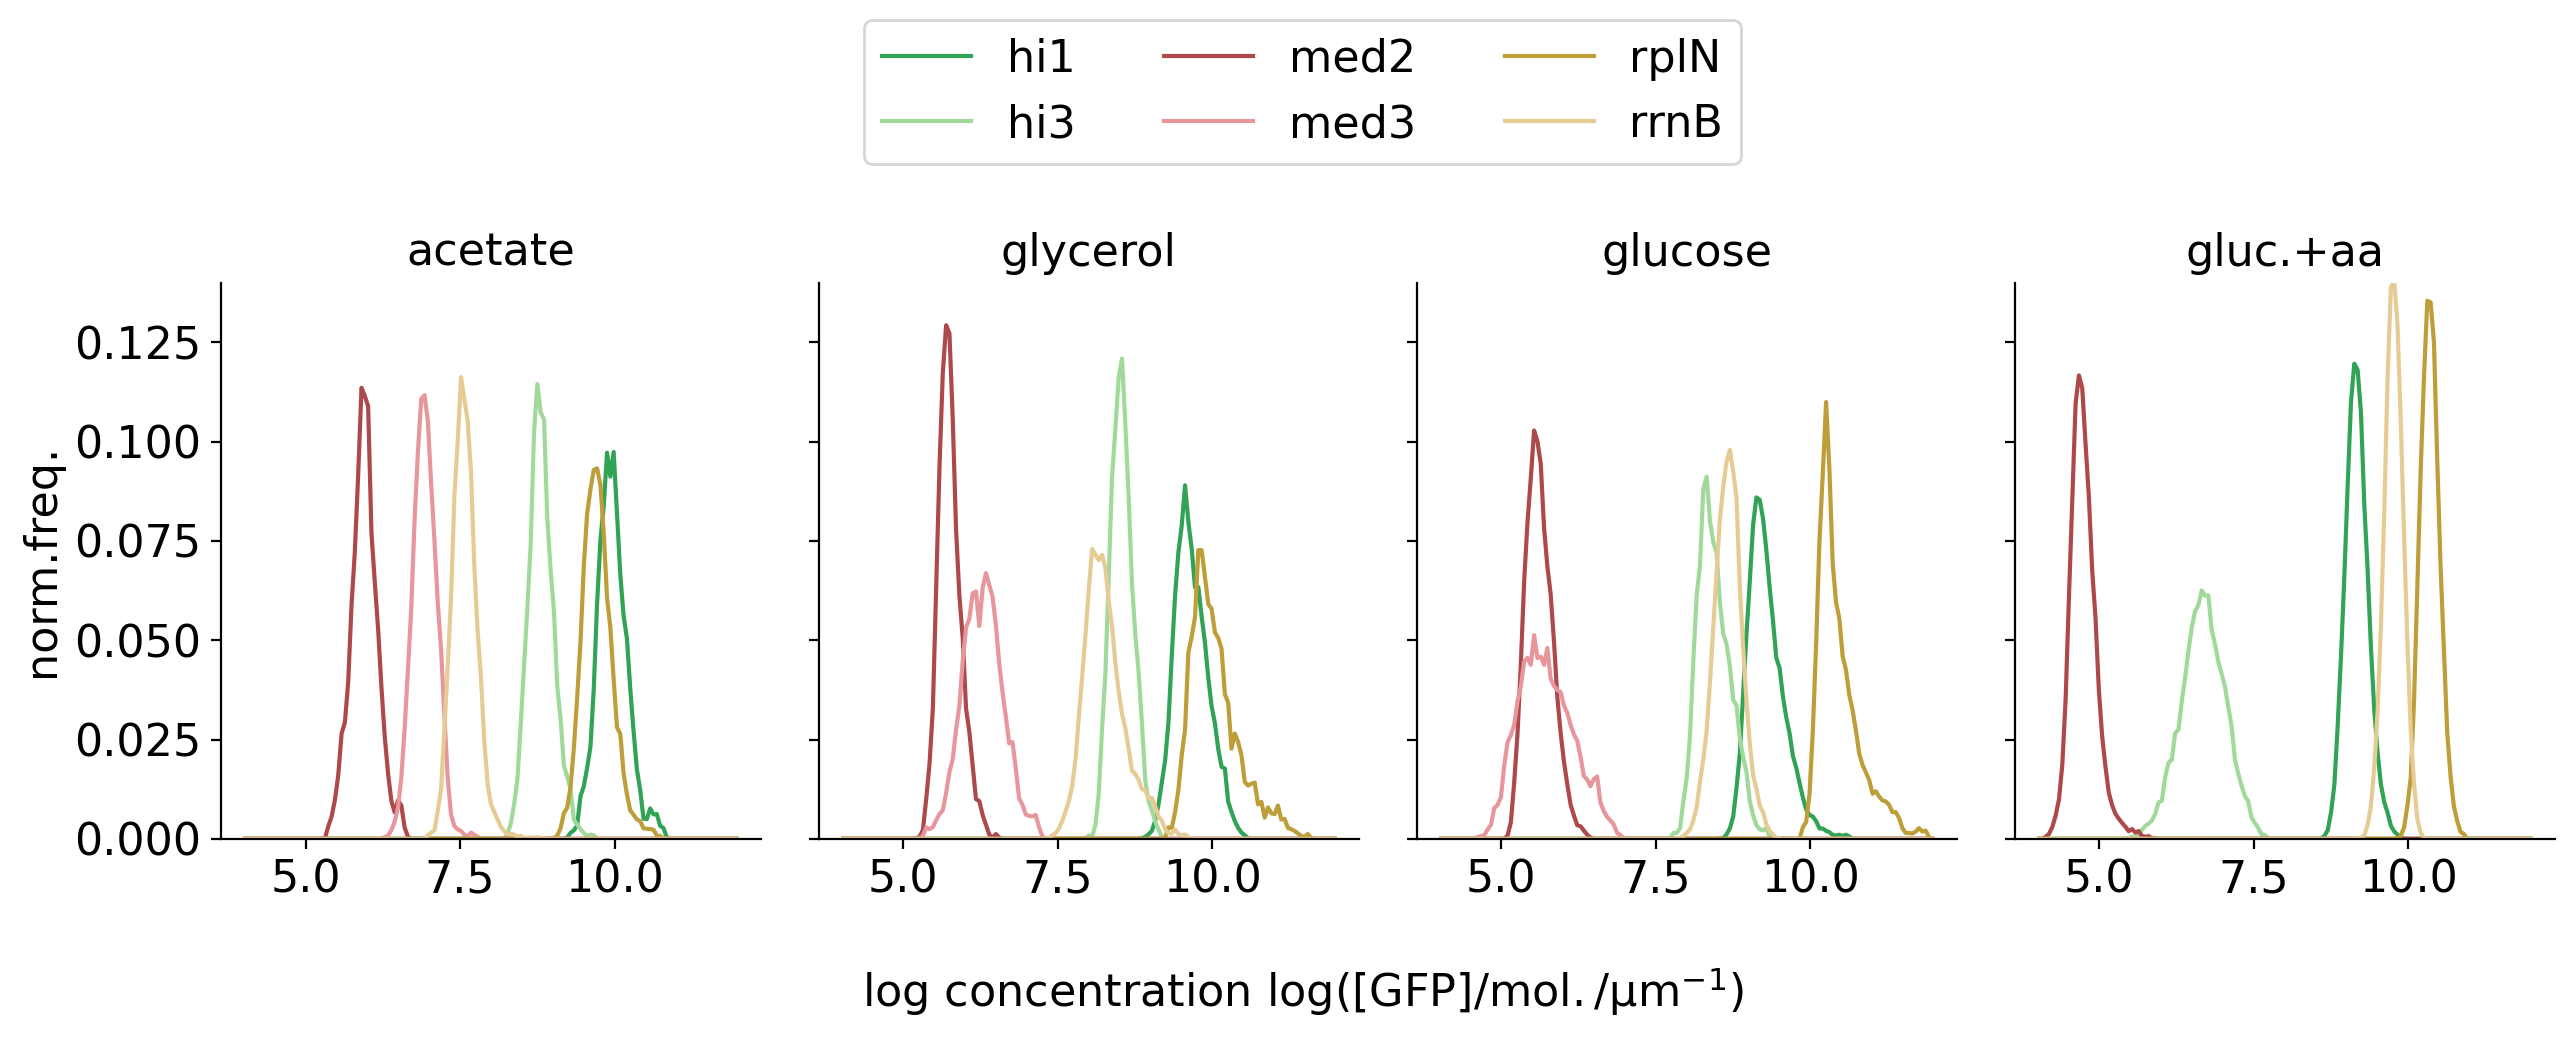

In [15]:
def plot_concentration_noise(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(1,4, figsize=(FULL_SIZE,FULL_SIZE/3), sharex=True, sharey=True)
    ax = axes.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_xlim(-1,6)
        a.set_ylim(0, 0.14)
        # a.set_yscale("log")

    for i, condition in enumerate(conditions):
        ax[i].set_title(label_by_condition[condition])
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            cells = samples[sample]['ggp_cells']
            log_concentration = np.concatenate([cell.log_concentration for cell in cells])
            
            weight, bin_c = bin_with_error_bars(log_concentration, log_concentration*0, return_edges=False, ignore_errors=True, n_bins=np.linspace(4, 12, 150))
            weight= np.array(weight)/np.sum(weight)
            ax[i].plot(bin_c, weight, color=color_by_promoter[samples[sample]["promoter"]], label=samples[sample]["promoter"])
            # ax[0].plot(bin_c, weight, color=altcolor_by_condition[condition])
            
    fig.supxlabel("log concentration log([GFP]$/\mathrm{mol. /\mu m^{-1}}$)", y=0.04)
    ax[0].set_ylabel(r"norm.freq.")
    
    l = fig.legend(*legend_without_duplicate_labels(ax[0]),
            bbox_to_anchor=(0.5, 1), 
            loc="lower center", ncol=3)

        
    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()

plot_concentration_noise(first_replicates)
                           # plot_file="../../figures_for_fluctuations_paper/supp/production_rate_hist.pdf")


## Corr time

In [16]:
def get_time_at_corr(dts, rs, corr, only_positive=True):
    dts_inter = np.linspace(dts[0], dts[-1], 100)
    rs_inter=np.interp(dts_inter, dts, rs)
    if only_positive:
        return dts_inter[dts_inter>0][np.argmin(np.abs(rs_inter[dts_inter>0] - corr))]



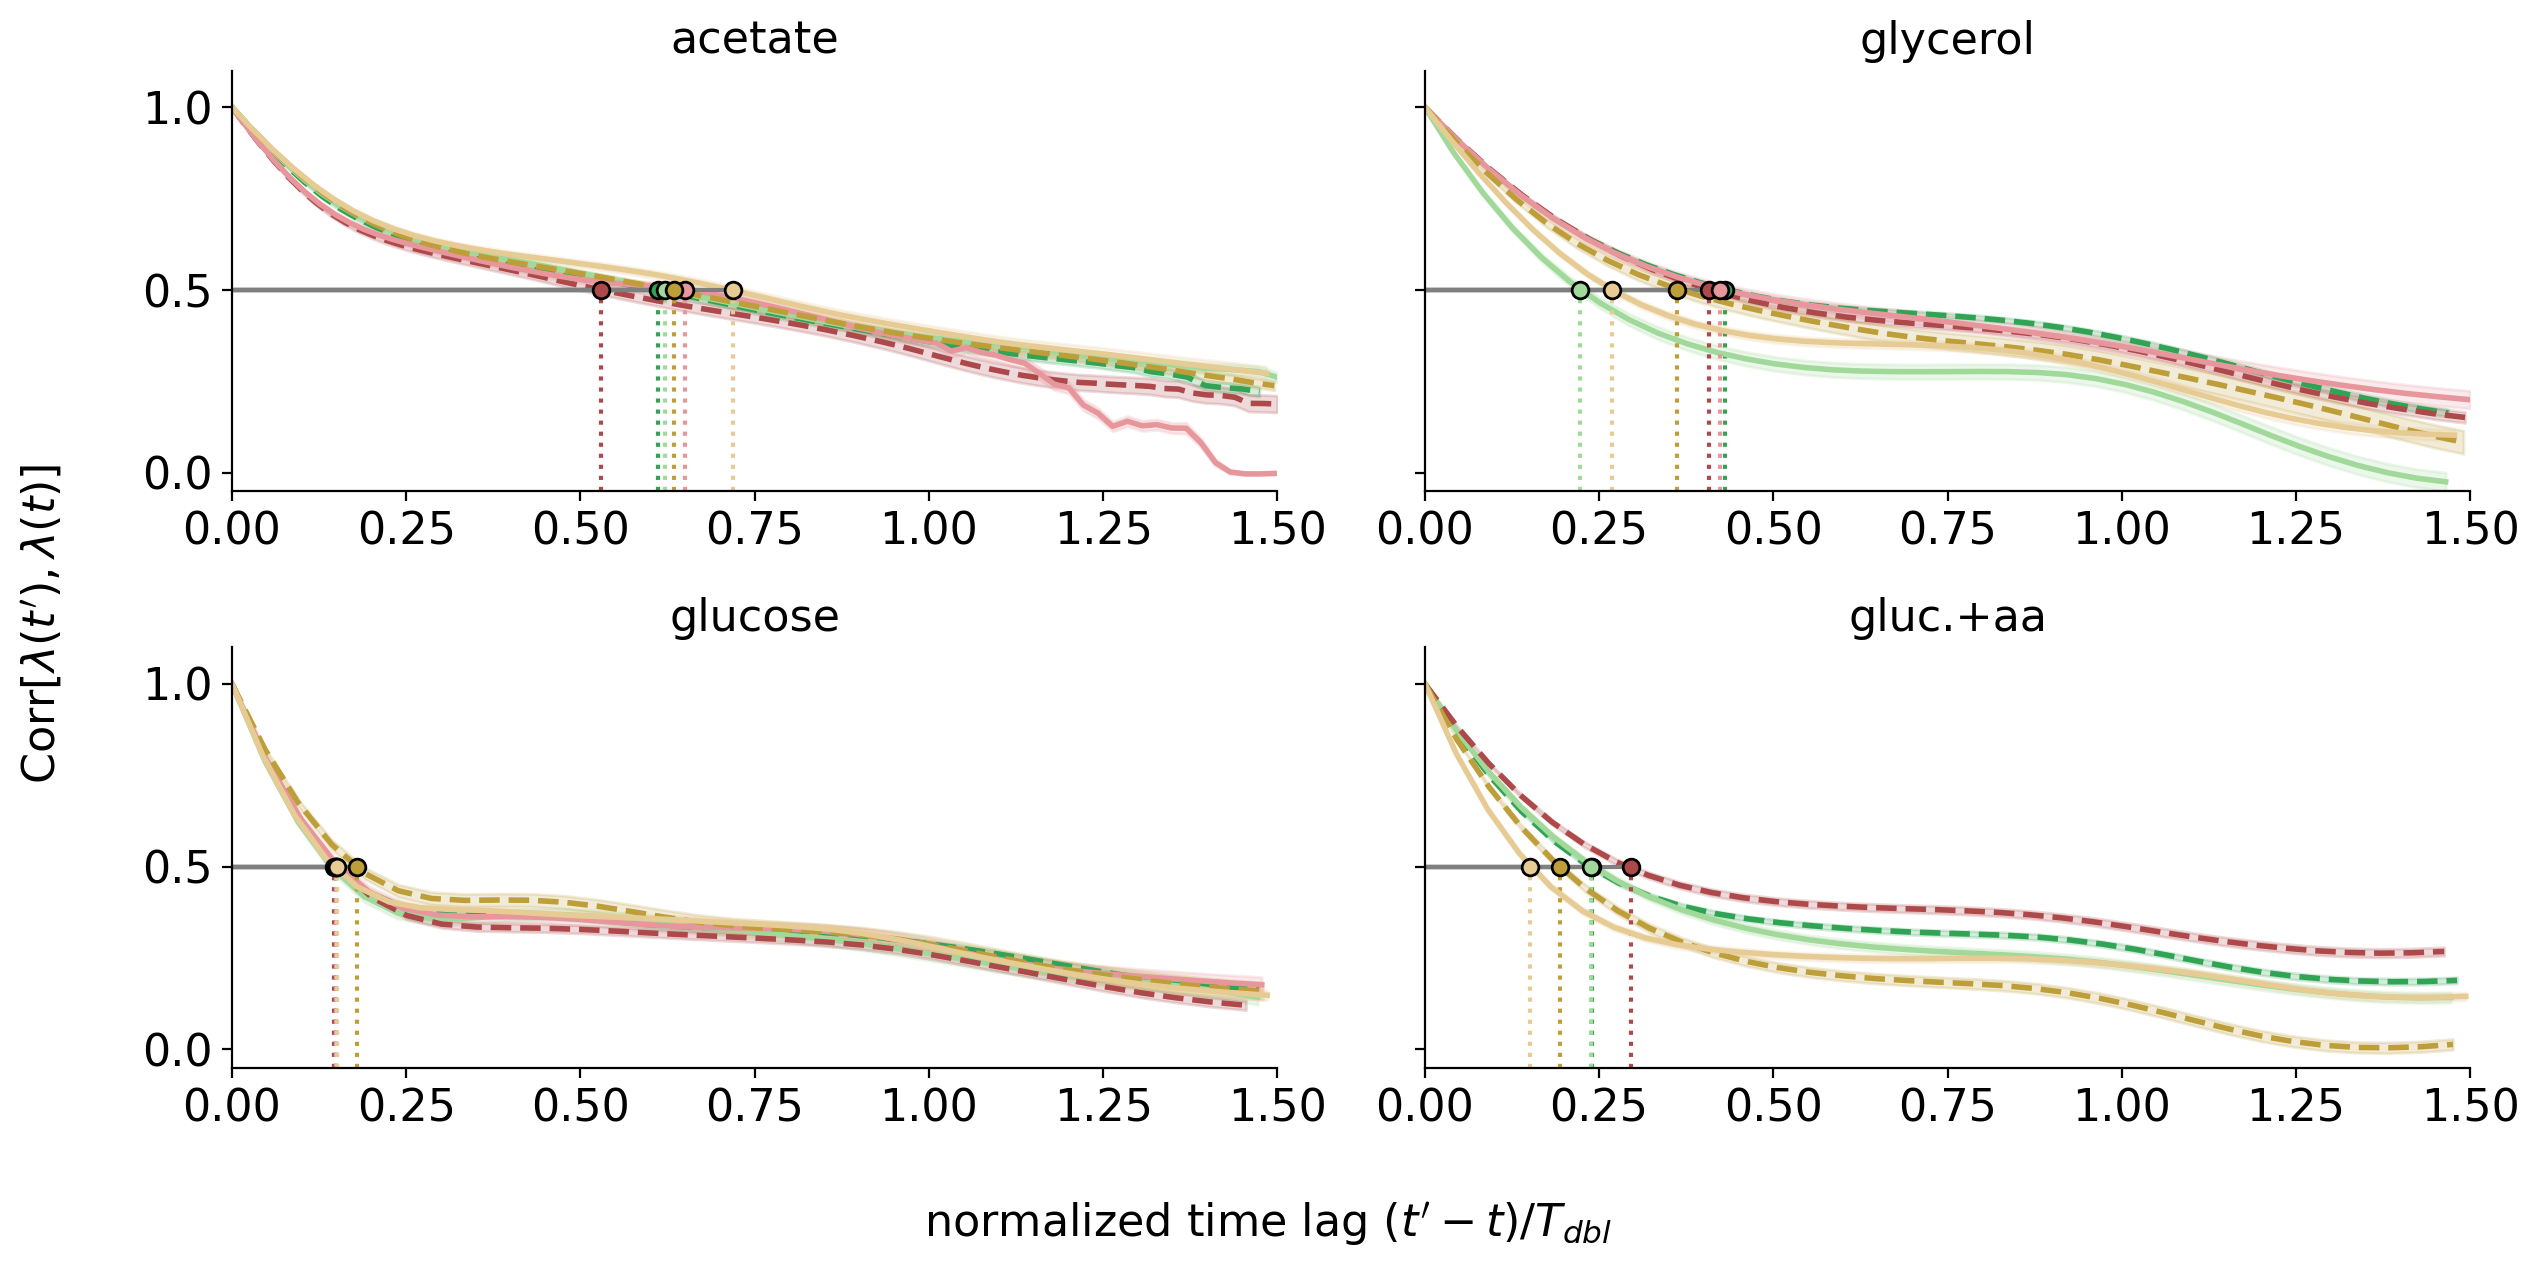

In [17]:
    
def plot_growth_rate_auto_corr_by_condition(samples, 
                        x,y, 
                        ylabel=None,
                        ylim=[None, None], 
                        xlim=[None, None], 
                        color_scheme="alt", 
                        plot_file=None):

    get_func=Correlation_function.get_corr_mle
    get_err_func=Correlation_function.get_corr_mle_err


    # =========== figure =========== #

    fig, ax = plt.subplots(2,2, figsize=(FULL_SIZE, FULL_SIZE/2), sharey=True, sharex=False)
    ax = ax.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        a.set_ylim(ylim)
        a.set_xlim(xlim)

    
    # =========== plot =========== #
    corr_at_mdt = {c:[] for c in conditions}
    dt_at_corr = {c:[] for c in conditions}

    for i, condition in enumerate(conditions):
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            
            correlation_function = copy.deepcopy(samples[sample]['correlation_function'])
            correlation_function.filter_by_n(100)
                        
            # =========== correlation =========== #
            dts = correlation_function.dt
            rs = get_func(correlation_function, x,y)
            errs = get_err_func(correlation_function, x,y)
            
            gamma_lambda = samples[sample]["parameters"]["gamma_lambda"][1]
                          
            mean_lambda = samples[sample]["l_mean"]
            promoter = samples[sample]["promoter"]
            
            dts /= (np.log(2.)/mean_lambda)
            gamma_lambda*=(np.log(2)/mean_lambda)
            
            if xlim!=[None,None]:
                dt_filter = (dts<=xlim[-1])*(dts>=xlim[0])
                dts=dts[dt_filter]
                rs=rs[dt_filter]
                errs=errs[dt_filter]

            if promoter in ["hi1", "med2", "rplN"]:
                ls ="--"
            else:
                ls = "-"
            # color = altcolor_by_condition[condition]
            color = color_by_promoter[promoter]
            ax[i].plot(dts, rs, lw=2, color=color, label=promoter, alpha=1, ls=ls)
            ax[i].fill_between(dts, rs-errs*2, rs+errs*2, color=color, alpha=0.2)
            ax[i].set_title(label_by_condition[condition])

            mark_corr = np.max(rs)*0.5
            corr_at_mdt[condition].append(get_corr_at_mdt(dts, rs, 1))
            dt_at_corr[condition].append(get_time_at_corr(dts,rs, mark_corr))     
            samples[sample]["dt_at_ll_corr"] = get_time_at_corr(dts,rs, mark_corr)
            samples[sample]["corr_at_mdt"] = get_corr_at_mdt(dts, rs, 1)

            ax[i].vlines(get_time_at_corr(dts,rs, mark_corr), ylim[0], mark_corr, color=color, alpha=1, ls=':')
            ax[i].scatter(get_time_at_corr(dts,rs, mark_corr), mark_corr, color=color, alpha=1, ec="black", zorder=10)
            ax[i].hlines(mark_corr, 0, get_time_at_corr(dts,rs, mark_corr), color="tab:grey", alpha=1, ls='-')
#             if promoter=="hi1":
#                 ax[i].scatter(get_time_at_corr(dts,rs, mark_corr), mark_corr, color=color, alpha=0.8, ec="black", zorder=10)
#                 ax[i].vlines(get_time_at_corr(dts,rs, mark_corr), ylim[0], mark_corr, color=color, alpha=0.8, ls='--')
#                 ax[i].hlines(mark_corr, 0, get_time_at_corr(dts,rs, mark_corr), color=color, alpha=1, ls='--')
                
            
    # for i, condition in enumerate(conditions):
    
        # c = np.mean(corr_at_mdt[condition])
        # ax[i].vlines(1, 0, c, color="tab:grey", alpha=0.8, ls='--')
        # ax[i].hlines(c, 0, 1, color="tab:grey", alpha=0.8, ls='--')
        # ax[i].scatter(1, c , color="tab:grey", alpha=0.8, zorder=5)

        # t = np.mean(dt_at_corr[condition])
        # ax[i].vlines(t, 0, mark_corr, color="tab:grey", alpha=0.8, ls='--')
        # ax[i].hlines(mark_corr, 0, t, color="tab:grey", alpha=0.8, ls='--')
        # ax[i].scatter(t, mark_corr , color="tab:grey", alpha=0.8, zorder=5, ec="black")
        # ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        # ax[i].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))

        # c = np.around(c, decimals=2)
        # ax[i].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))

    fig.supylabel(ylabel)

    fig.supxlabel(r'normalized time lag $(t^\prime-t)/T_{dbl}$', y=0.02)

    fig.tight_layout()
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white", bbox_inches="tight")
        plt.show()
        
    else:
        plt.show()
    plt.close()
    return samples

first_replicates = plot_growth_rate_auto_corr_by_condition(first_replicates, 
                        "l(t+dt)", "l(t)", 
                        ylabel=r"Corr$[\lambda(t^\prime),\lambda(t)]$",
                        ylim=[-0.05, 1.1], 
                        xlim=[0, 1.5], )
                        # plot_file="../../figures_for_fluctuations_paper/supp/auto_corr_lambda.pdf",)

Saved in ../../figures_for_fluctuations_paper/supp/auto_corr_q.pdf


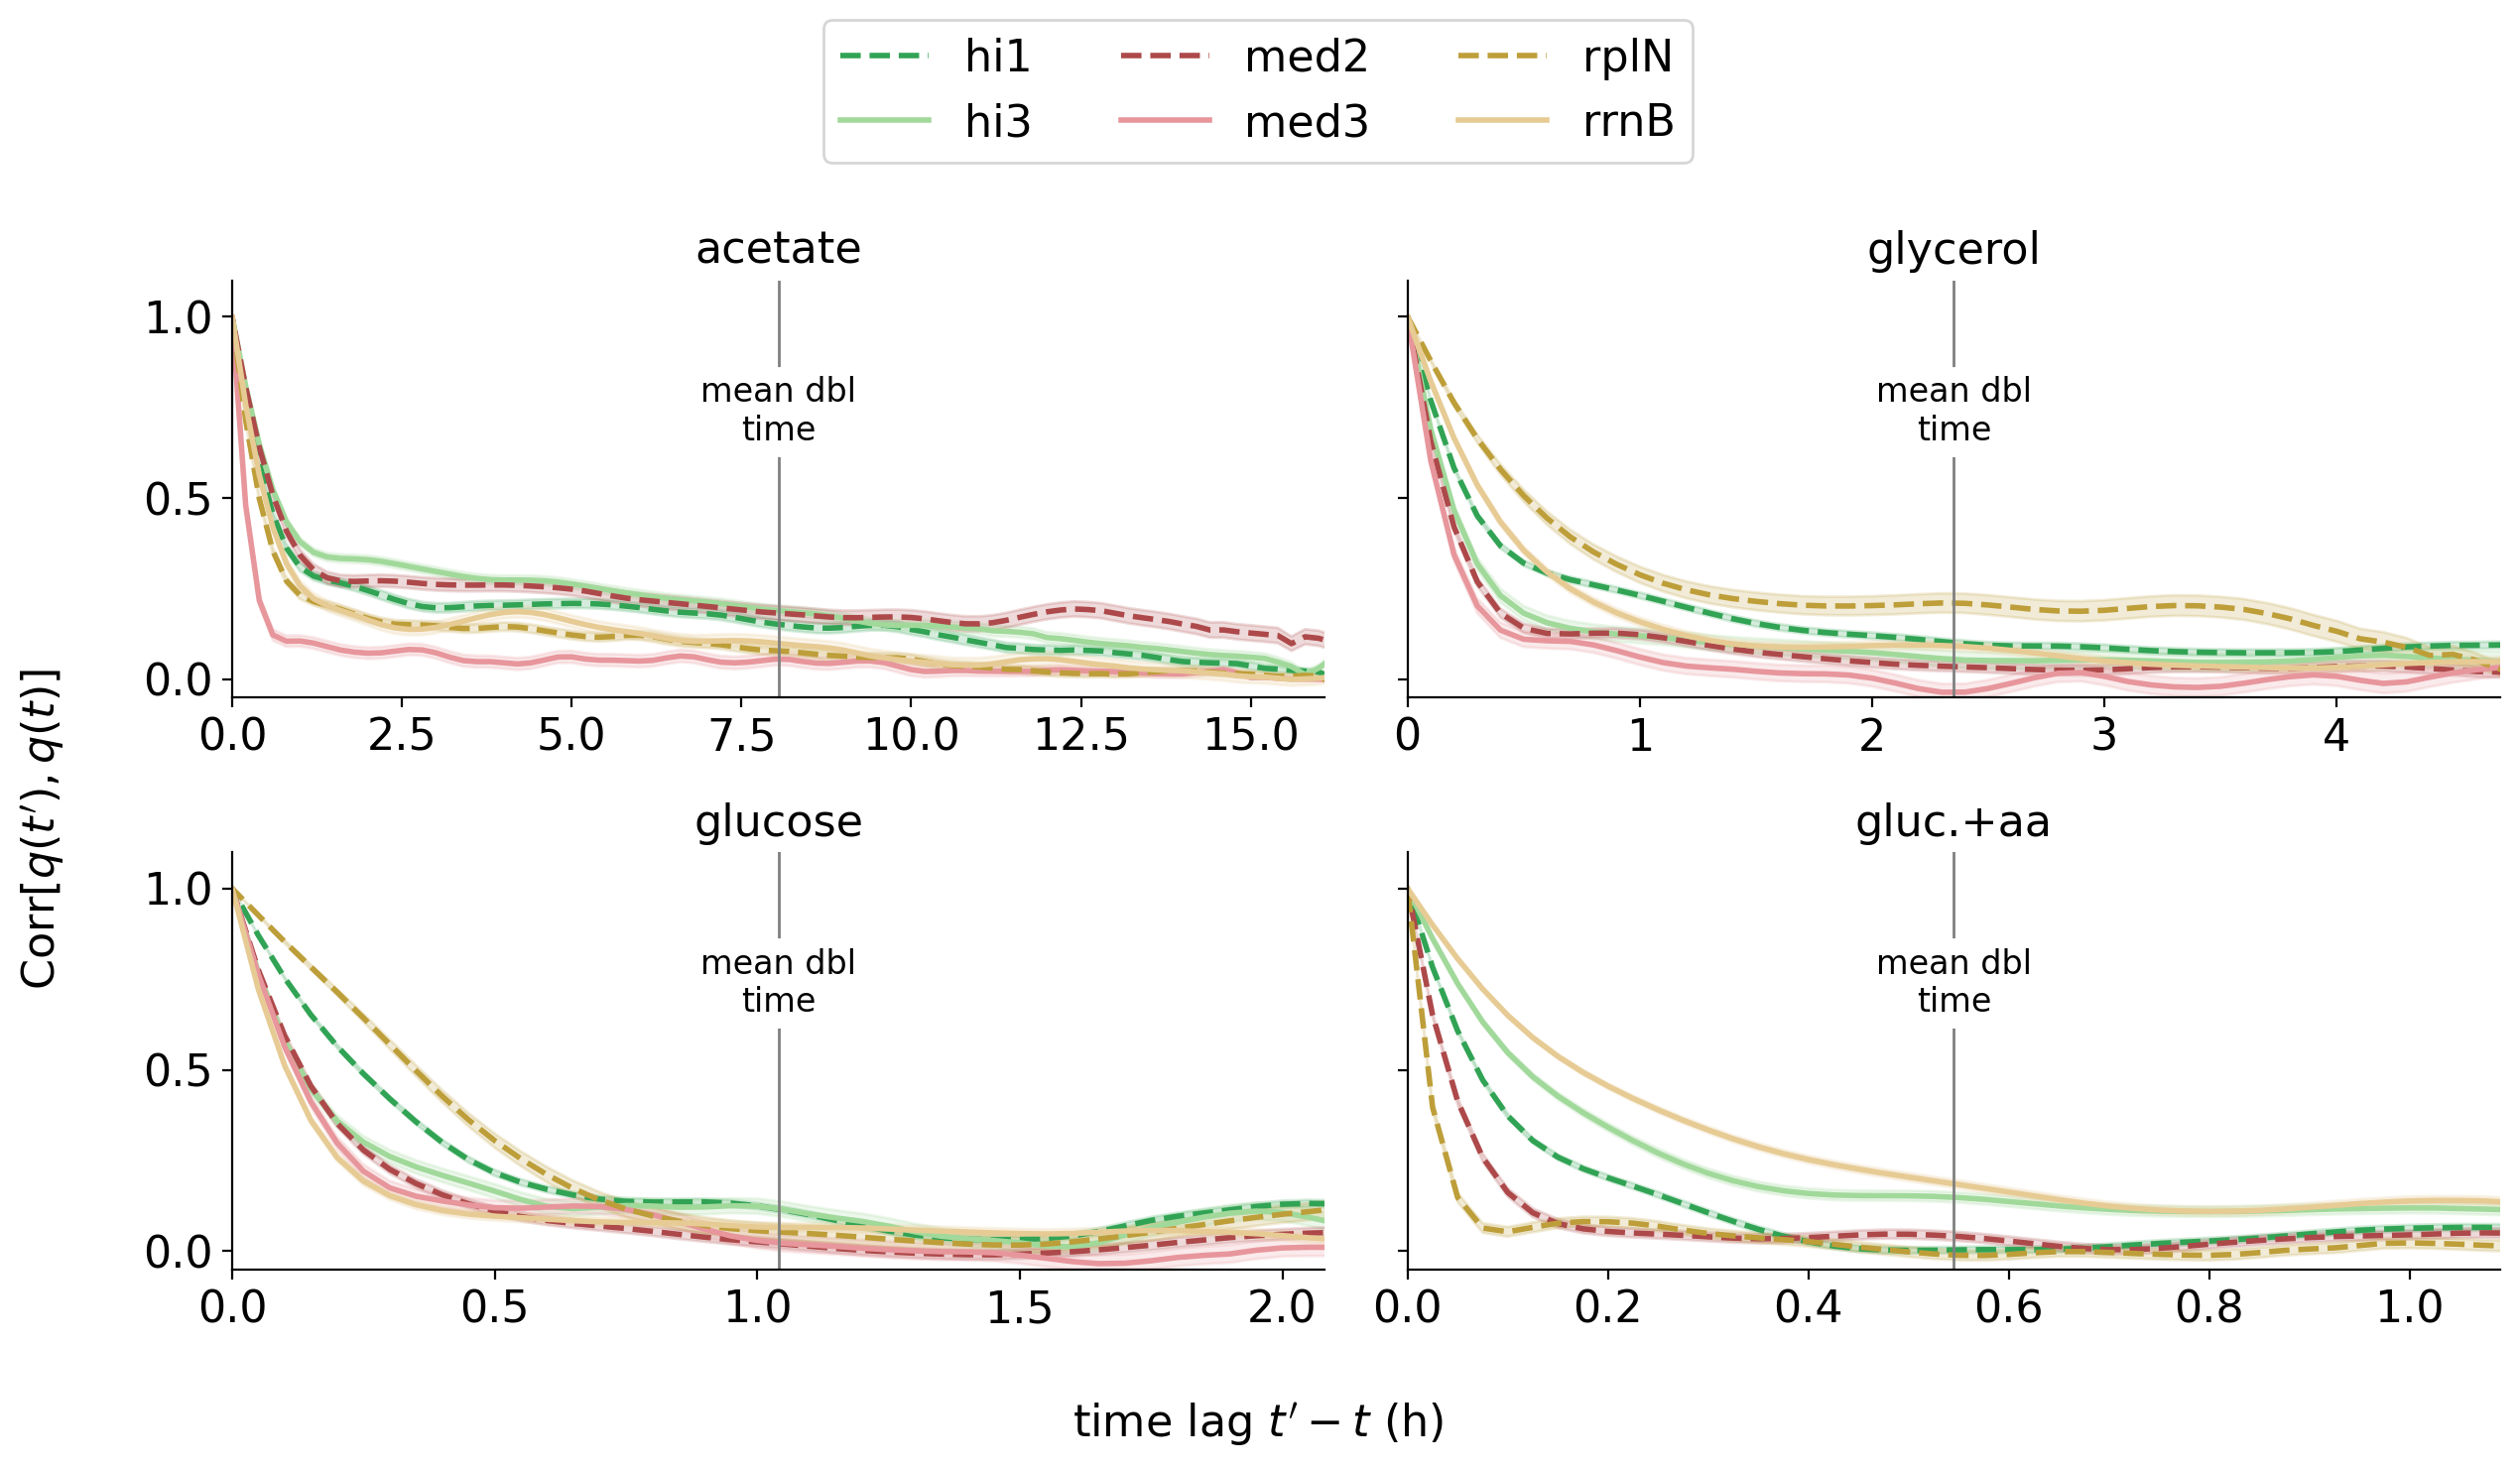

In [18]:
def plot_prod_rate_auto_corr_by_condition(samples, 
                        x,y, 
                        ylabel=None,
                        ylim=[None, None], 
                        xlim=[None, None], 
                        color_scheme="alt", 
                        plot_file=None):

    get_func=Correlation_function.get_corr_mle
    get_err_func=Correlation_function.get_corr_mle_err


    # =========== figure =========== #

    fig, ax = plt.subplots(2,2, figsize=(FULL_SIZE, FULL_SIZE/2), sharey=True, sharex=False)
    ax = ax.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        a.set_ylim(ylim)
        a.set_xlim(xlim)
    
    # =========== plot =========== #
    corr_at_mdt = {c:[] for c in conditions}
    dt_at_corr = {c:[] for c in conditions}

    for i, condition in enumerate(conditions):
        avg_dbl = []
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            
            correlation_function = copy.deepcopy(samples[sample]['correlation_function'])
            correlation_function.filter_by_n(500)
                        
            # =========== correlation =========== #
            dts = correlation_function.dt
            rs = get_func(correlation_function, x,y)
            errs = get_err_func(correlation_function, x,y)
            
            gamma_lambda = samples[sample]["parameters"]["gamma_lambda"][1]
                          
            mean_lambda = samples[sample]["l_mean"]
            promoter = samples[sample]["promoter"]
            
            dts /= 60.
            # gamma_lambda*=()
            
            avg_dbl.append(np.log(2)/mean_lambda/60)
            
            if xlim!=[None,None]:
                dt_filter = (dts<=xlim[-1])*(dts>=xlim[0])
                dts=dts[dt_filter]
                rs=rs[dt_filter]
                errs=errs[dt_filter]
                
            if promoter in ["hi1", "med2", "rplN"]:
                ls ="--"
            else:
                ls = "-"
            
            color = color_by_promoter[promoter]
            ax[i].plot(dts, rs, lw=2, color=color, label=promoter, alpha=1, ls=ls)
            ax[i].fill_between(dts, rs-errs*2, rs+errs*2, color=color, alpha=0.2)
            ax[i].set_title(label_by_condition[condition])
            
        ax[i].set_xlim(0, np.mean(avg_dbl)*2)
        ax[i].axvline(np.mean(avg_dbl), color="grey", lw=1)
        
        ax[i].text(np.mean(avg_dbl), ax[i].get_ylim()[-1]*0.6, 
                "mean dbl\ntime", 
                color="black",
                backgroundcolor='w', 
                ha='center', fontsize=SMALL_SIZE)
        
    # ax[0].set_xlim(0, 20)
    # ax[1].set_xlim(0, 3)
    # ax[2].set_xlim(0, 2)
    # ax[3].set_xlim(0, 1)
    fig.supylabel(ylabel)        
    fig.supxlabel(r'time lag $t^\prime-t$ (h)', y=0.02)
    
    l = fig.legend(*legend_without_duplicate_labels(ax[0]),
                bbox_to_anchor=(0.5, 1), 
                loc="lower center", ncol=3)

    fig.tight_layout()
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white", bbox_inches="tight")
        plt.show()
        
    else:
        plt.show()
    plt.close()
    return None

plot_prod_rate_auto_corr_by_condition(first_replicates, 
                                "q(t+dt)", "q(t)", 
                                ylabel=r"Corr$[q(t^\prime),q(t)]$",
                                ylim=[-0.05, 1.1], 
                                plot_file="../../figures_for_fluctuations_paper/supp/auto_corr_q.pdf")


In [19]:
# ace

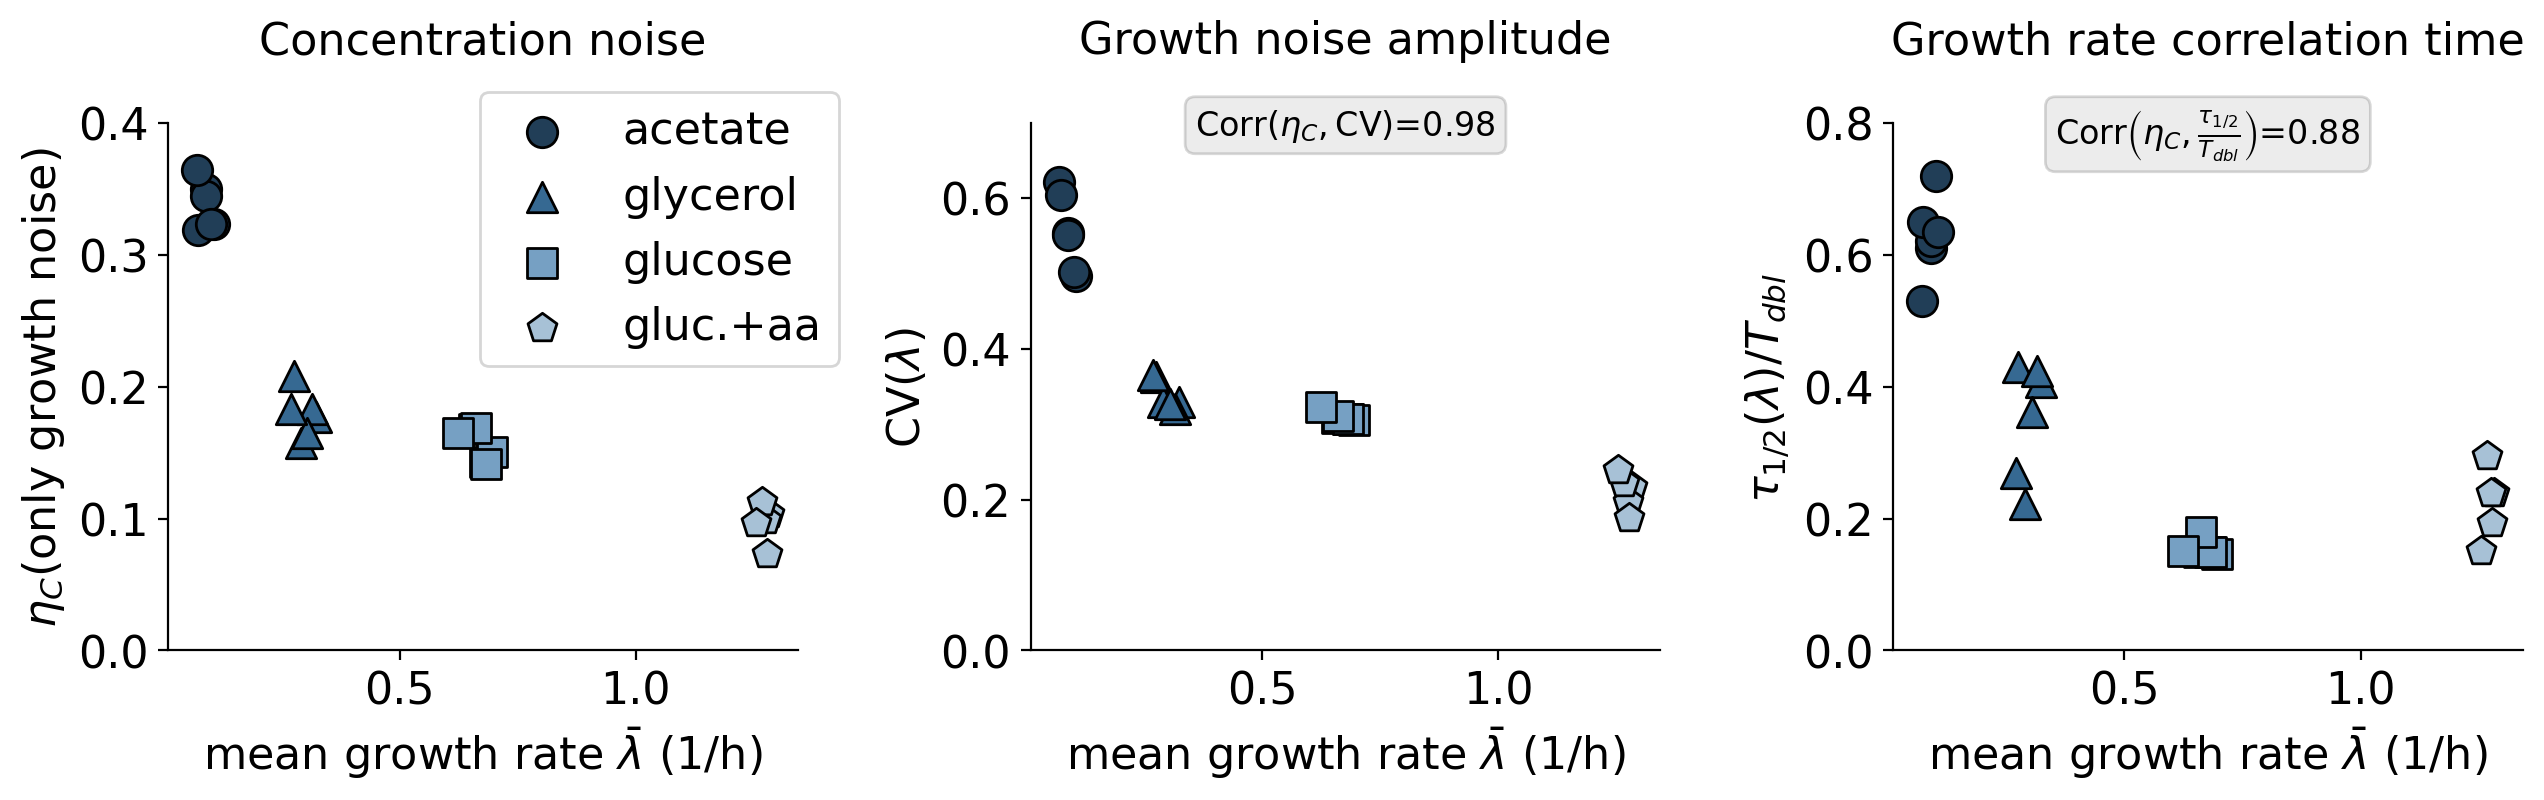

In [20]:
def get_corr_string(x,y,decimals=2):
    c = np.around(np.corrcoef(x,y)[0,1], decimals)
    return "{:.2f}".format(c) 

def plot_iqr_cv_corr_time(samples, noise_settings=[], plot_file=None):
    fig, ax = plt.subplots(1,3, figsize=(FULL_SIZE,FULL_SIZE/3))
    # fig, ax = plt.subplots(1,1, figsize=(7.5,4))
    ax = ax.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_ylim(0,0.8)

    mean_ls = []
    cv_ls = []
    iqrs = []
    dt_at_corrs = []
    
    for i, promoter in enumerate(promoters):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            # color = color_by_both[samples[sample]["promoter"]][samples[sample]["condition"]]
            marker = marker_by_condition[samples[sample]["condition"]]

            mean_ls.append(samples[sample]["l_mean"]*60)
            cv_ls.append(samples[sample]["l_cv"])
            iqrs.append(get_log_concentration_iqr(samples[sample][noise_settings[1]]))
            dt_at_corrs.append(samples[sample]["dt_at_ll_corr"])


            # color = color_by_promoter[samples[sample]["promoter"]]
            color = color_by_condition[samples[sample]["condition"]]
            # color="tab:grey"
            label= label_by_condition[samples[sample]["condition"]]
            ax[0].scatter(mean_ls[-1], iqrs[-1], color=color, s=120,ec="black", marker = marker, label=label)                
            ax[1].scatter(mean_ls[-1], cv_ls[-1], color=color,s=120,  ec="black", marker = marker)
            ax[2].scatter(mean_ls[-1], dt_at_corrs[-1], color=color,s=120, ec="black", marker = marker)

    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)

    ax[1].text(0.5, 1.03, r"Corr$(\eta_C,$CV)="+get_corr_string(iqrs,cv_ls), 
                   transform=ax[1].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top', horizontalalignment='center', bbox=props)    
    
    ax[2].text(0.5, 1.03, r"Corr$\left(\eta_C, \frac{\tau_{1/2}}{T_{dbl}}\right)$="+get_corr_string(iqrs,dt_at_corrs), 
                   transform=ax[2].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top', horizontalalignment='center', bbox=props)
    
    for a in ax:
        a.set_xlabel(r"mean growth rate $\bar{\lambda}$ (1/h)")
        a.set_xlabel(r"mean growth rate $\bar{\lambda}$ (1/h)")
        a.set_xlabel(r"mean growth rate $\bar{\lambda}$ (1/h)")

        
    ax[0].set_ylabel(r"$\eta_C$(only growth noise)")
    ax[0].set_title(r"Concentration noise", y=1.1)
    ax[0].set_ylim(0,0.4)
        
    ax[1].set_ylabel(r"CV($\lambda$)")
    ax[1].set_title(r"Growth noise amplitude", y=1.1)
    ax[1].set_ylim(0,0.7)
    
    ax[2].set_ylabel(r"$\tau_{1/2}(\lambda)/T_{dbl}$")
    ax[2].set_title(r"Growth rate correlation time", y=1.1)
    ax[2].set_ylim(0,0.8)
    

    l = ax[0].legend(*legend_without_duplicate_labels(ax[0], sorting=list(label_by_condition.values())), 
               bbox_to_anchor=(1.1, 1.1),
               loc="upper right", 
               ncol=1)   
    

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()


setting_to_compare = ["cells", "cells_no_div_no_prod_noise"]

plot_iqr_cv_corr_time(first_replicates, 
                      noise_settings=setting_to_compare, 
                      plot_file="../../figures_for_fluctuations_paper/mean_gr_cv_lambda_iqr_corr_time.pdf")

In [21]:
legend_without_duplicate_labels

<function plotting_src.read_utils.legend_without_duplicate_labels(ax, sorting=None)>

## Cross corr

Saved in ../../figures_for_fluctuations_paper/cross_corr.pdf


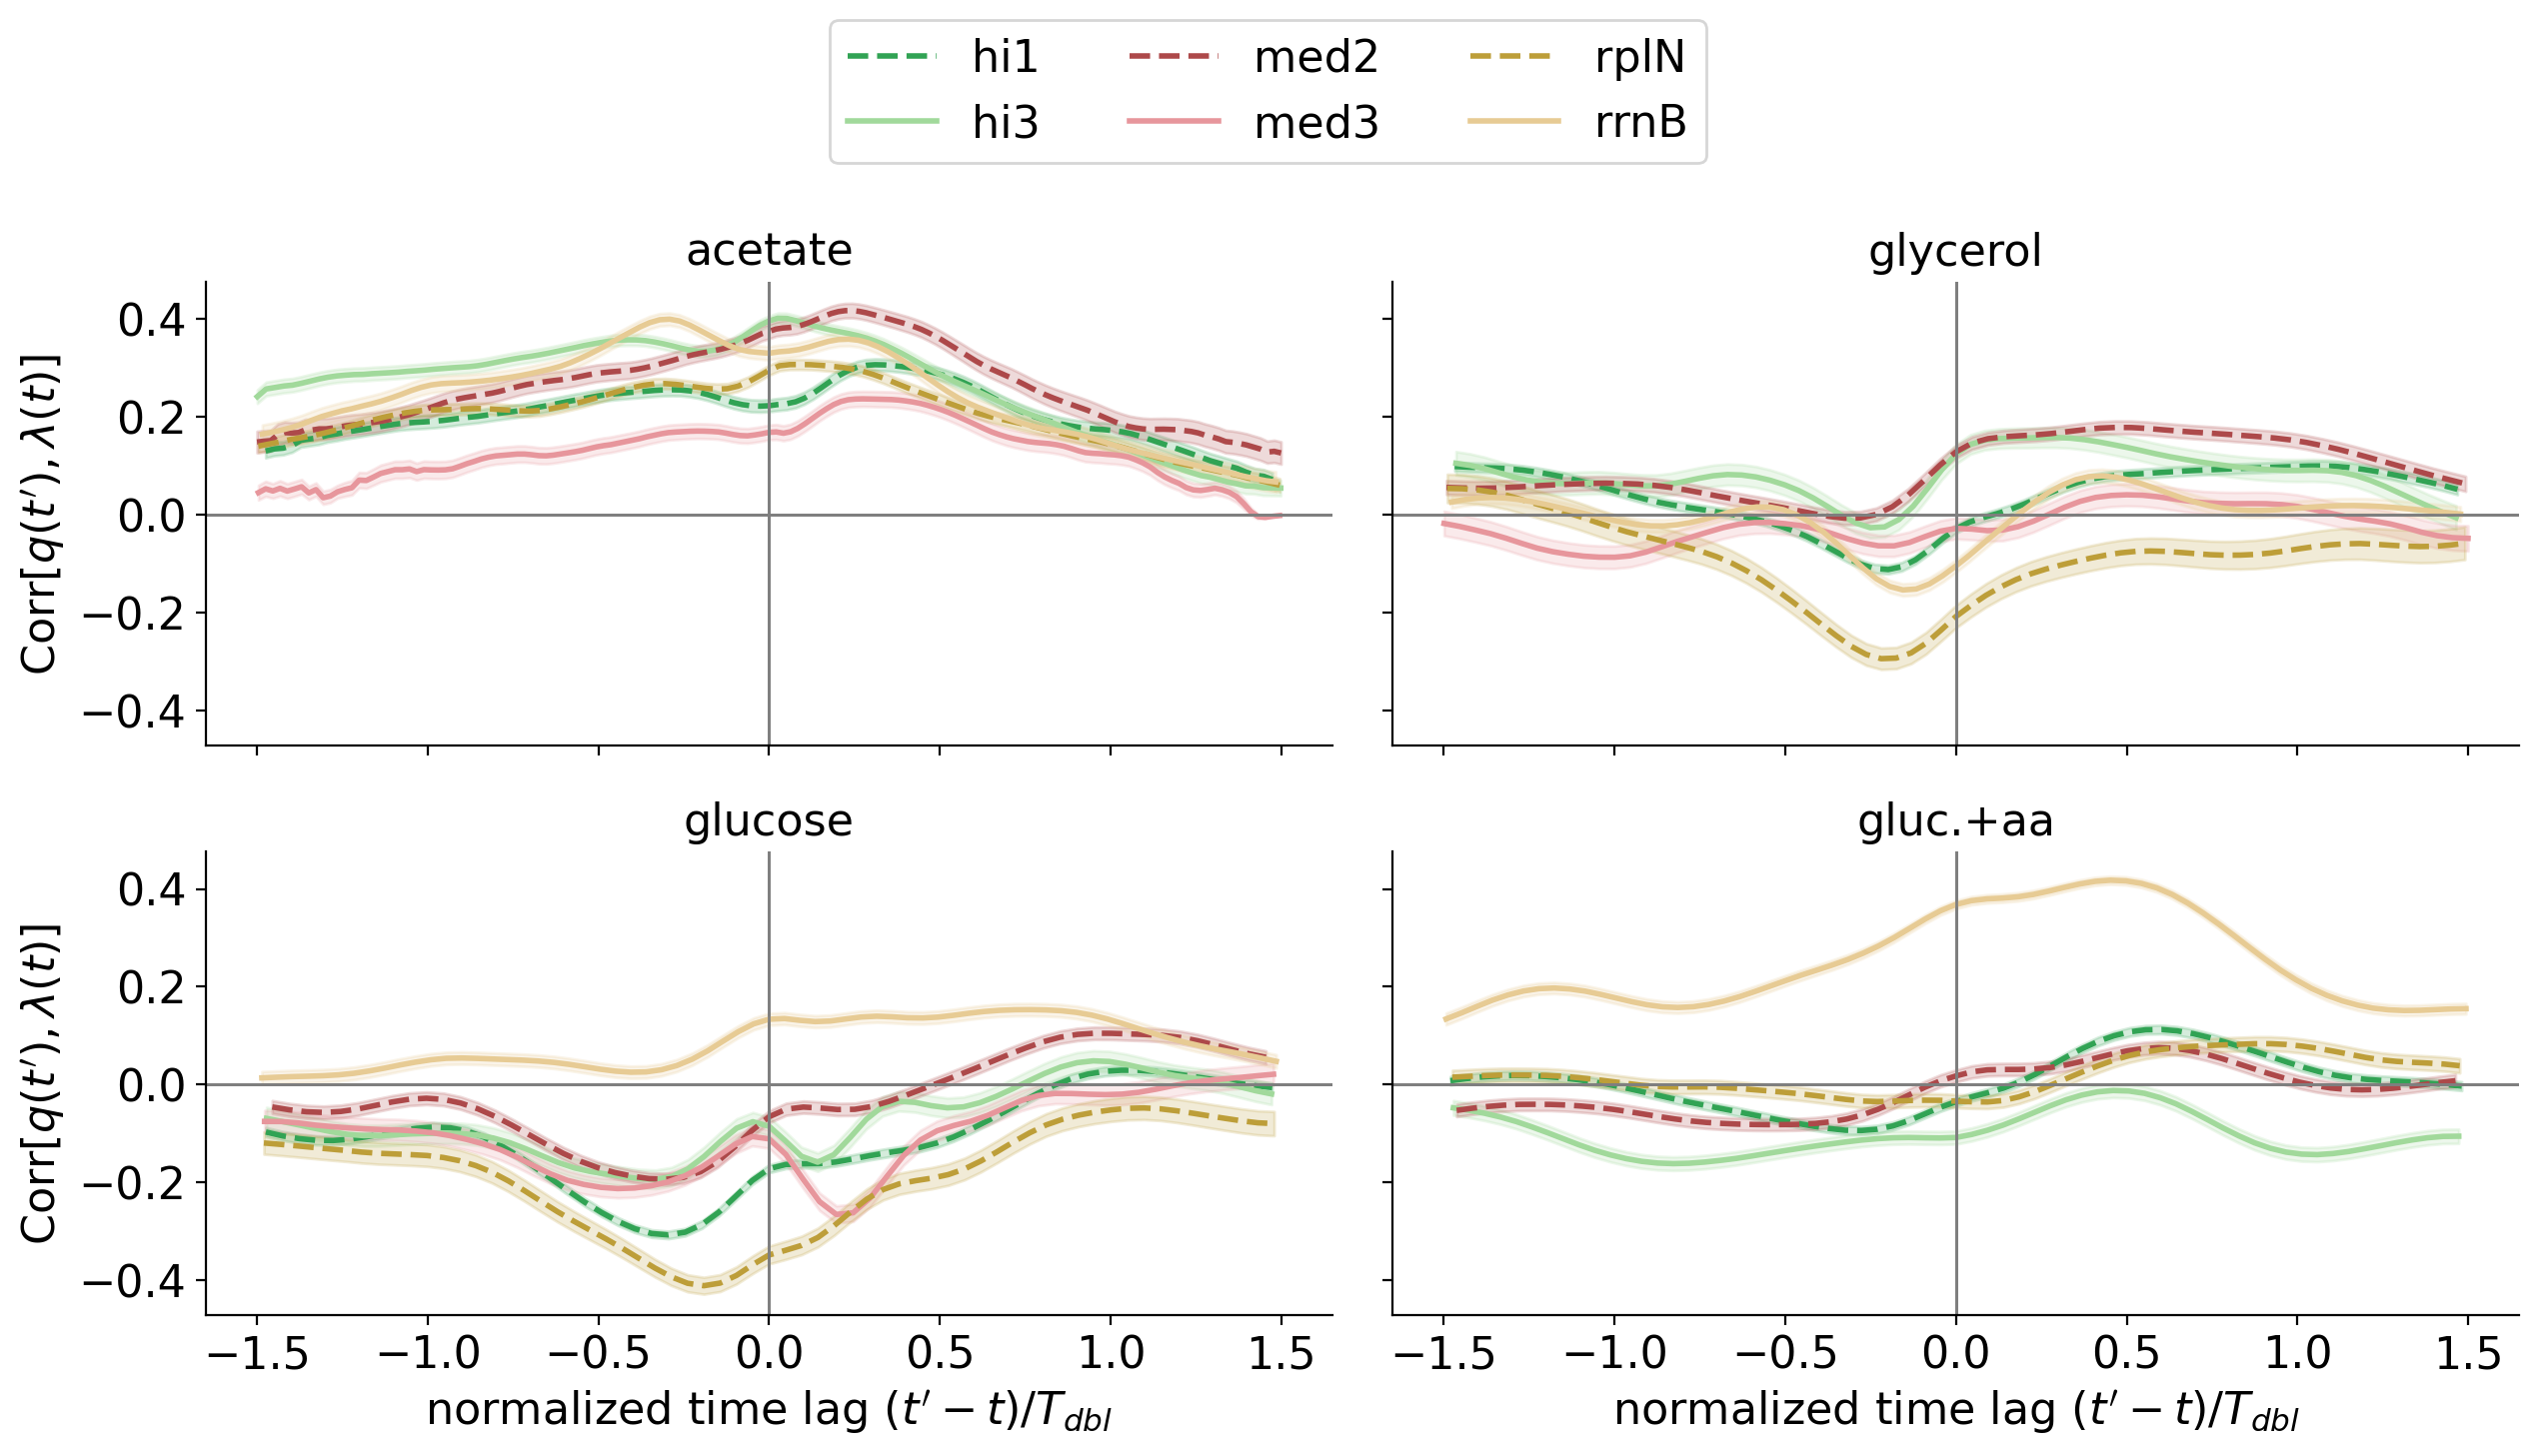

In [22]:
def plot_cross_coor(samples, x, y, 
                    plot_file=None, 
                    normalize=None,
                    xlim=[None, None],
                    ylim=[None,None], 
                    ylabel=None,
                    log=False, 
                    fit=False, 
                    highlight_x0=False,
                    highlight_y0=False,
                    corr_type="cov", 
                    color_by="condition",
                    legend=True,
                    title=None):


    get_func=Correlation_function.get_corr_mle
    get_err_func=Correlation_function.get_corr_mle_err

    # =========== figure =========== #

    fig, ax = plt.subplots(2, 2, figsize=(FULL_SIZE, FULL_SIZE/2), sharey=True, sharex=True)
    ax = ax.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        # set the x-spine
#         ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    # =========== plot =========== #
    corr_at_mdt = {c:[] for c in conditions}

    for i, condition in enumerate(conditions):
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            
            correlation_function = copy.deepcopy(samples[sample]['correlation_function'])
            correlation_function.filter_by_n(100)
                        
            # =========== correlation =========== #
            dts = correlation_function.dt
            rs = get_func(correlation_function, x,y)
            errs = get_err_func(correlation_function, x,y)


            gamma_lambda = samples[sample]["parameters"]["gamma_lambda"][1]
                          
            mean_lambda = samples[sample]["l_mean"]
            promoter = samples[sample]["promoter"]
            
            dts /= (np.log(2.)/mean_lambda)
            gamma_lambda*=(np.log(2)/mean_lambda)


            if xlim!=[None,None]:
                dt_filter = (dts<=xlim[-1])*(dts>=xlim[0])
                dts=dts[dt_filter]
                rs=rs[dt_filter]
                errs=errs[dt_filter]

            color = color_by_promoter[promoter]
            if promoter in ["hi1", "med2", "rplN"]:
                ls ="--"
            else:
                ls = "-"
            ax[i].plot(dts, rs, lw=2, color=color, label=promoter, alpha=1, ls=ls)
            ax[i].fill_between(dts, rs-errs*2, rs+errs*2, color=color, alpha=0.2)
            ax[i].set_title(label_by_condition[condition])
            
            ax[i].axhline(0,color="tab:grey", lw=1,)
            ax[i].axvline(0,color="tab:grey", lw=1,)

            ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            # ax[i].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            # ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
            
            ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
            # ax[i].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
        


    if ylim != [None, None]:
        new_ylim = ylim

    if legend:
        ncol=3
        fig.legend(*legend_without_duplicate_labels(ax[0]), 
                   loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=6)

    ax[0].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)
        
    # fig.supxlabel(r'$dt/$(mean doubling time)', y=0.13)
    ax[2].set_xlabel(r'normalized time lag $(t^\prime-t)/T_{dbl}$')
    ax[3].set_xlabel(r'normalized time lag $(t^\prime-t)/T_{dbl}$')
    
                                     
    l = fig.legend(*legend_without_duplicate_labels(ax[0]),
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", ncol=3)

    fig.tight_layout()
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white", bbox_inches="tight")
        plt.show()
        
    else:
        plt.show()
    plt.close()
            
plot_cross_coor(first_replicates, 
                        "q(t+dt)", "l(t)", 
                        ylabel=r"Corr$[q(t^\prime),\lambda(t)]$",
                        ylim=[-0.5, 0.5], 
                        xlim=[-1.5,1.5], 
                        # log=True, 
                        corr_type="corr",
                        legend=False, 
                        color_by="condition",
                        title=None,
                        plot_file="../../figures_for_fluctuations_paper/cross_corr.pdf",)




## Division

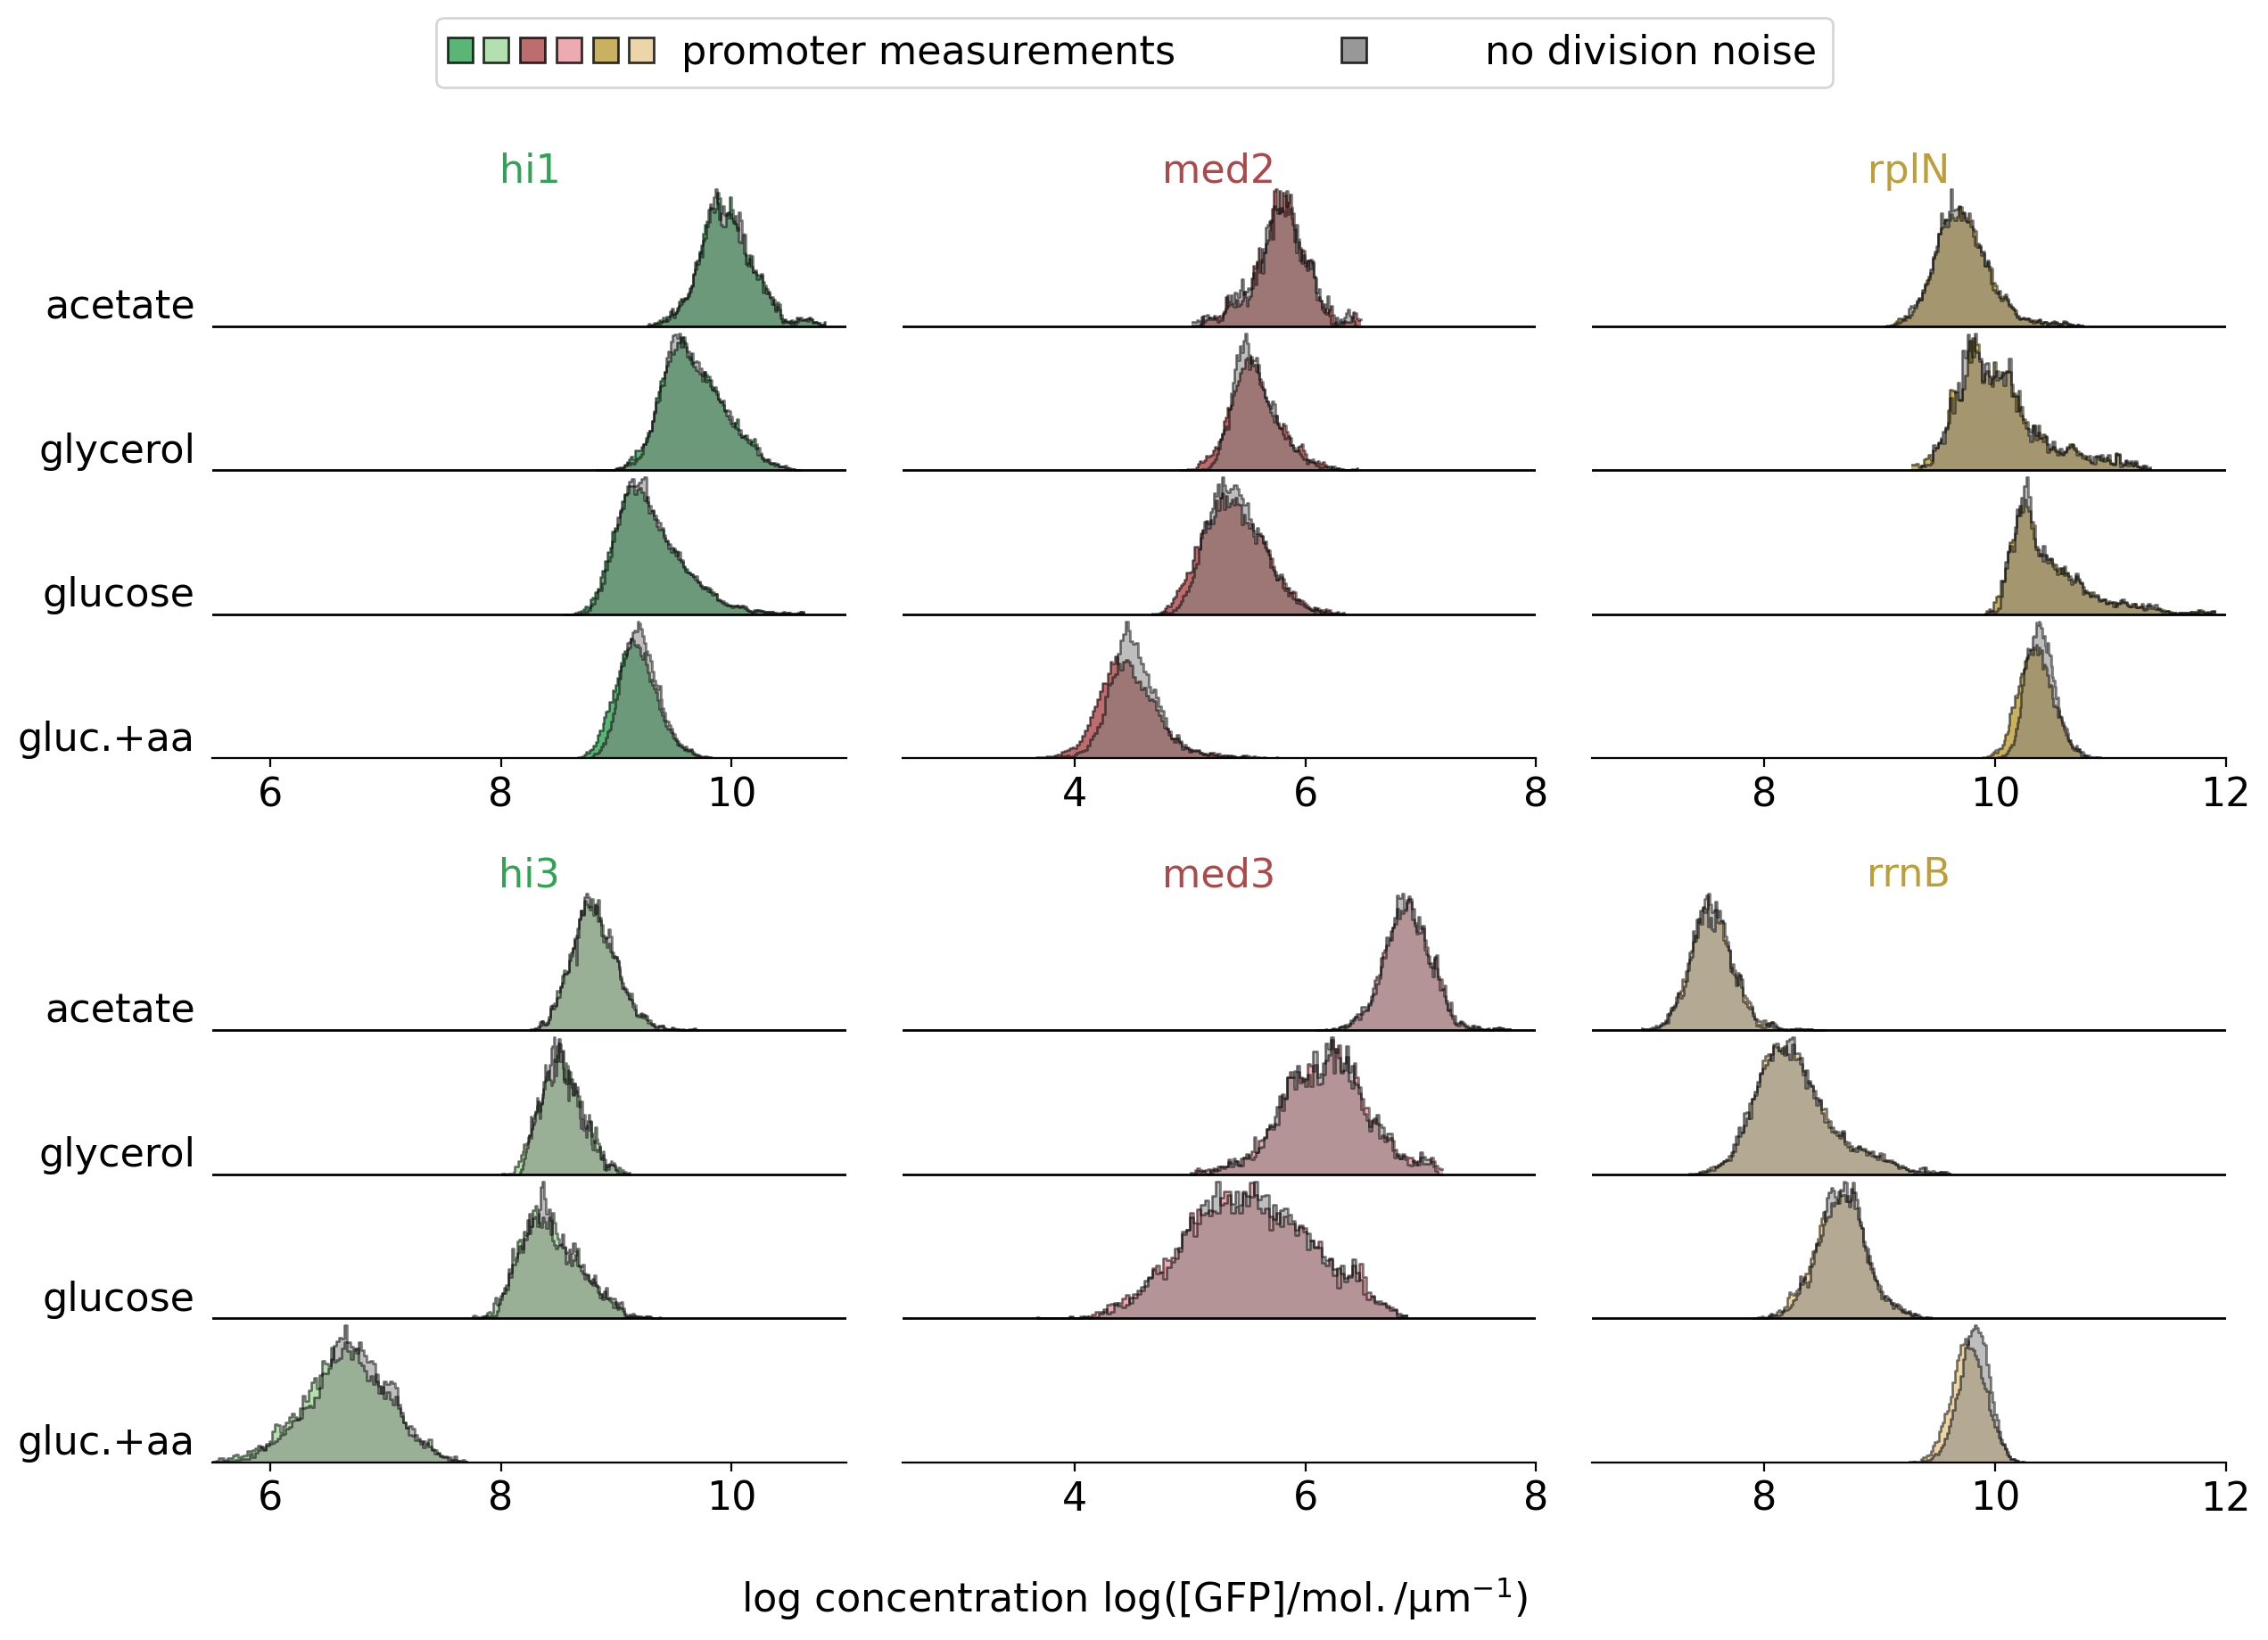

In [23]:
setting_to_compare = ["cells", "cells_no_div_noise"]
plot_log_concentration_histograms_v(first_replicates, 
                                    hist_width=0.95, 
                                    noise_settings=setting_to_compare, 
                                    grey_label="no division noise",
                                    second_color="tab:grey",
                                    plot_file="../../figures_for_fluctuations_paper/supp/no_div_noise_hist.pdf")

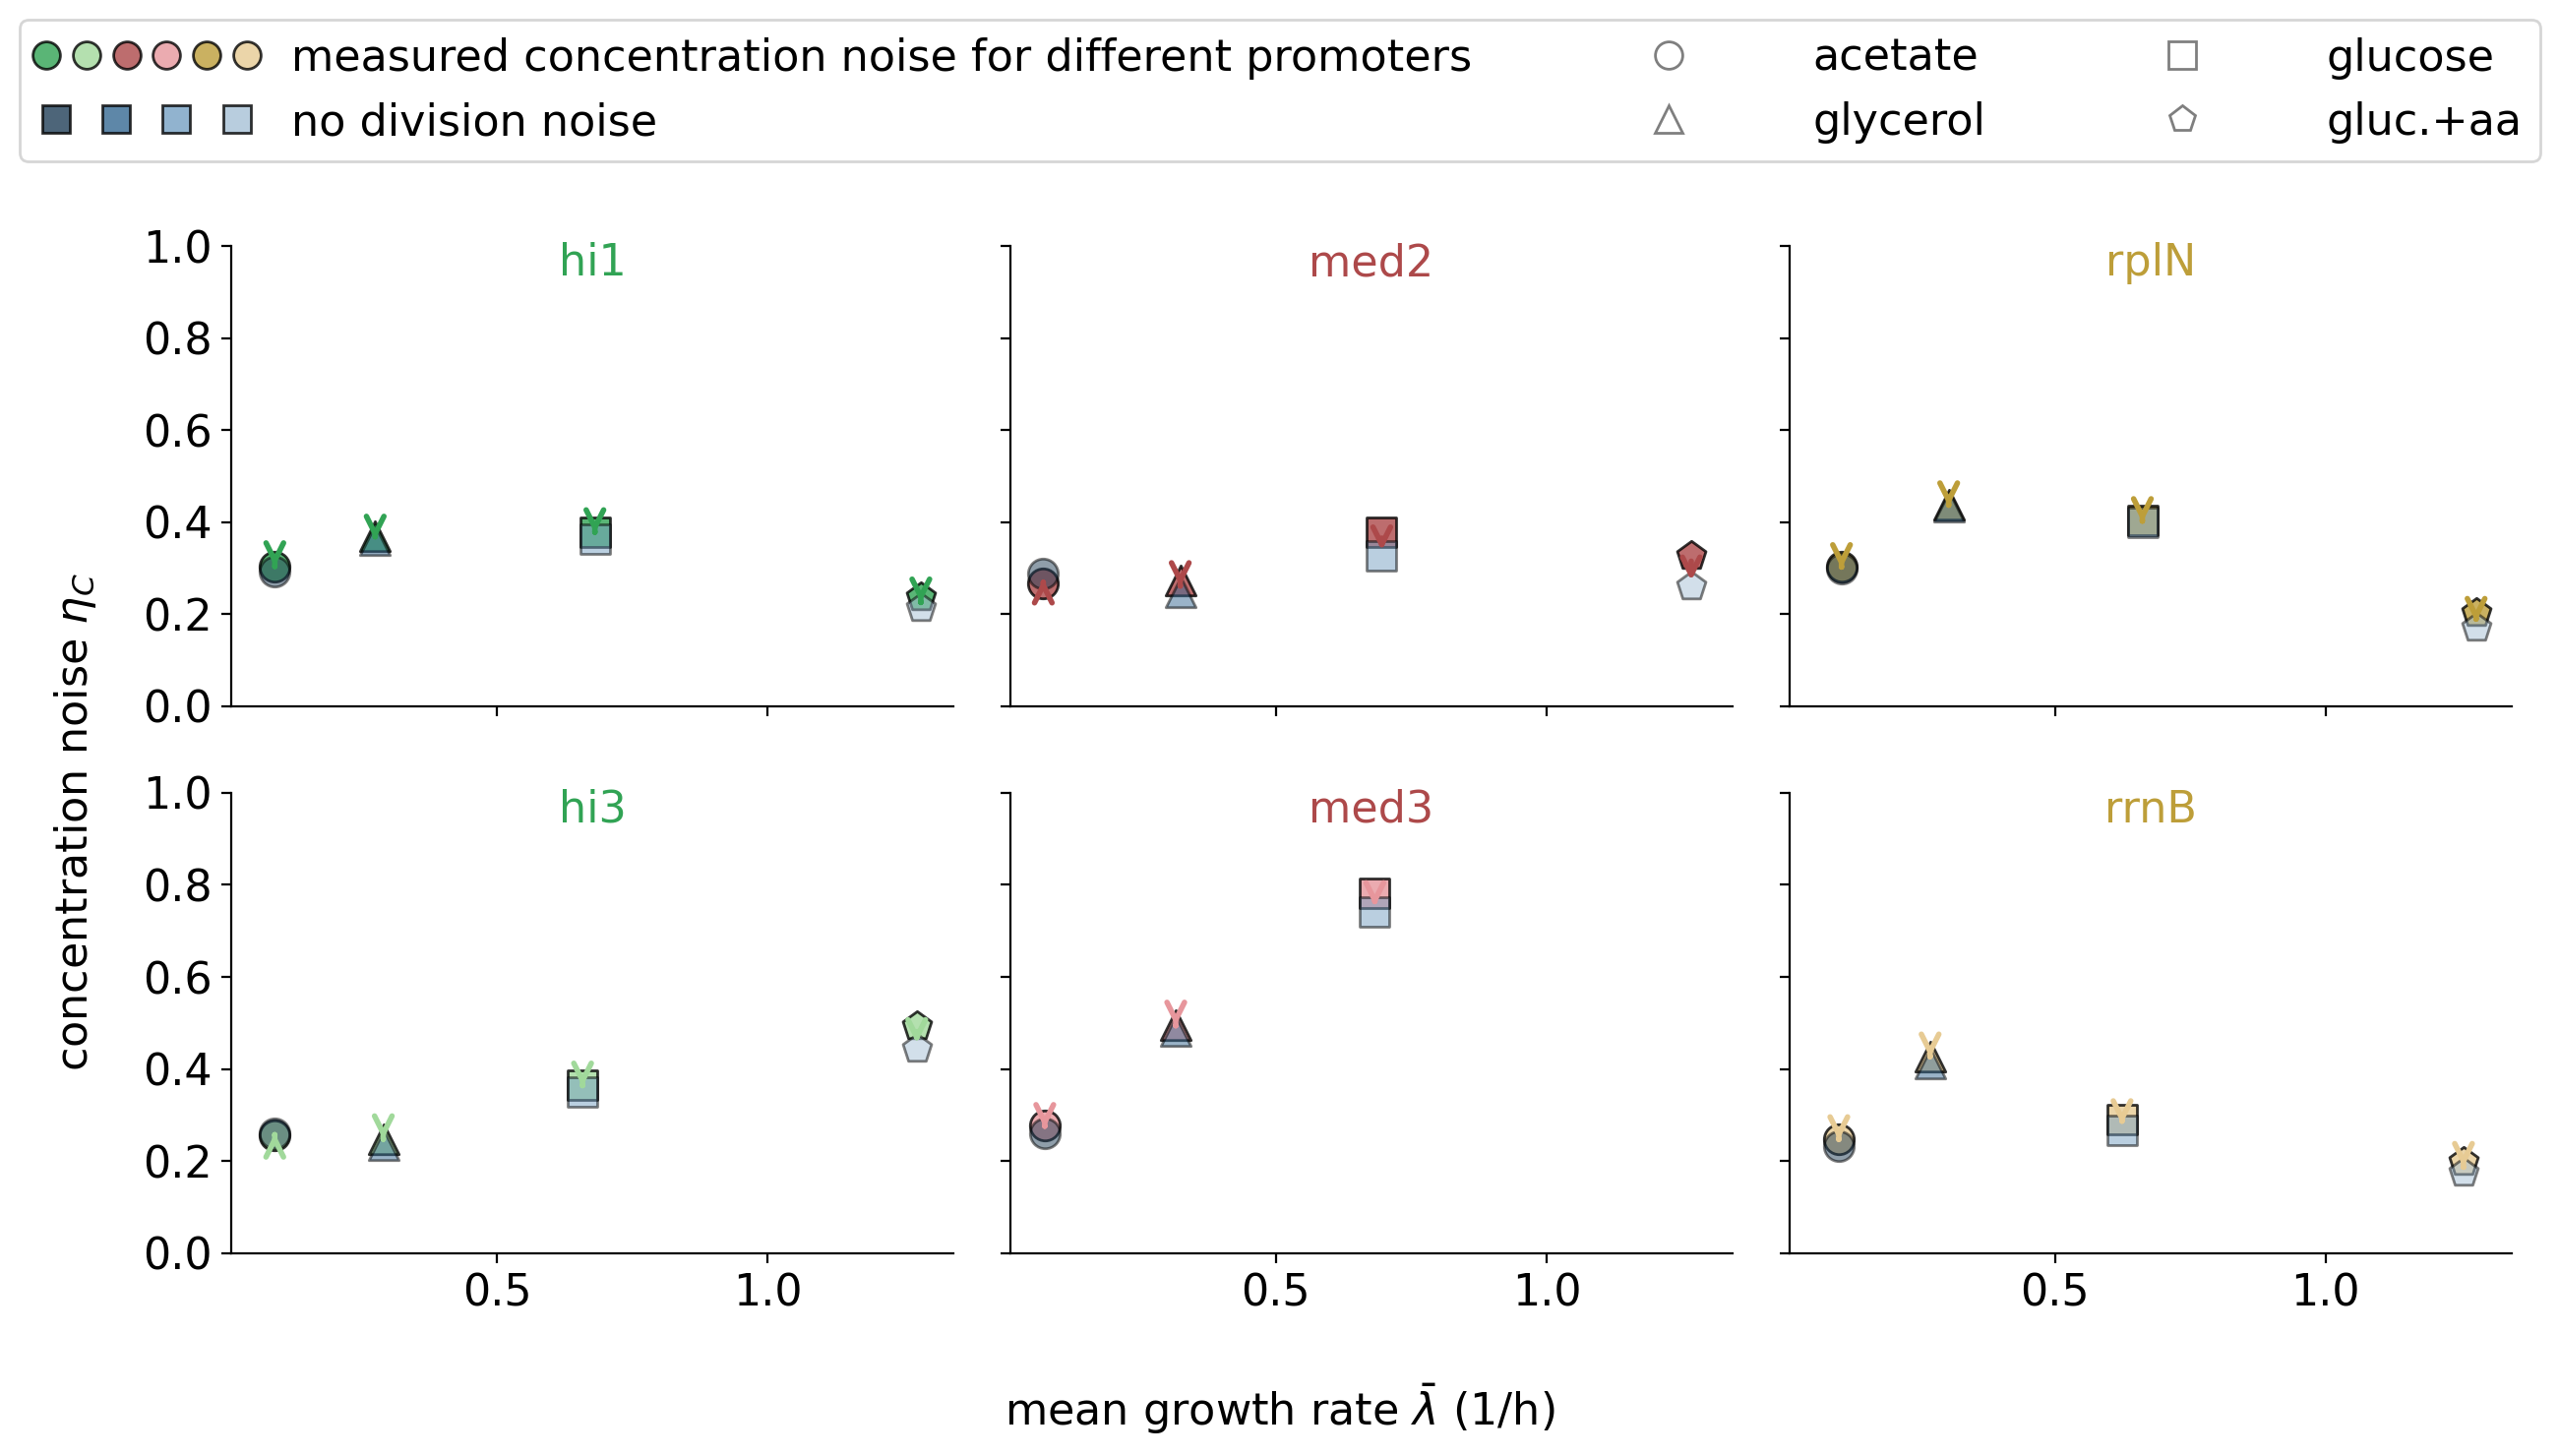

In [24]:
setting_to_compare = ["cells", "cells_no_div_noise"]


_ = plot_log_concentration_iqr(first_replicates, 
                           noise_settings=setting_to_compare, 
                           grey_label="no division noise",
                           plot_file="../../figures_for_fluctuations_paper/supp/no_div_IQR_changes.pdf")